In [3]:
from os import listdir
import xarray
import cftime
import numpy as np
import matplotlib.pyplot as plt
import xarray
from scipy.stats import ttest_ind
import numpy as np
from scipy.stats import linregress
from scipy.stats import norm
from matplotlib import rc
import regionmask


def sig_testing(all_ds, xaer_ds):
    all_array = all_ds.values
    xaer_array = xaer_ds.values

    def welch_t_test(all_pt, xaer_pt, lat, lon):
        t_val, p_val = ttest_ind(all_pt, xaer_pt, equal_var=False)
        return ((lat, lon), p_val)

    results = []
    for lati, lat in enumerate(all_ds.lat.values):
        for loni, lon in enumerate(all_ds.lon.values):
            all_pt = all_array[0:all_ds["member"].size, 0:all_ds["year"].size, lati, loni].flatten()
            xaer_pt = xaer_array[0:xaer_ds["member"].size, 0:xaer_ds["year"].size, lati, loni].flatten()
            t_value, p_value = ttest_ind(all_pt, xaer_pt, equal_var=False)
            results.append(((lat, lon), p_value))

    sig_results = (all_ds.mean(dim="member").mean(dim="year").load() * 0).rename("p-value")
    for (lat, lon), p_value in results:
        sig_results.loc[dict(lat=lat, lon=lon)] = p_value
    return sig_results

In [4]:
HEAD_DIR = "/projects/dgs/persad_research/heat_research/data/"

TREFHTMN_ALL = HEAD_DIR + "OUTPUT/METRICS/TREFHTMN/ALL/"
all_hwf_fut = xarray.open_mfdataset([TREFHTMN_ALL + name for name in listdir(TREFHTMN_ALL) if "20060101-20801231" in name], combine="nested", concat_dim="member")["HWF"].load()
all_hwf_hist = xarray.open_mfdataset([TREFHTMN_ALL + name for name in listdir(TREFHTMN_ALL) if "19200101-20051231" in name], combine="nested", concat_dim="member")["HWF"].load()
all_hwf_full = xarray.concat([all_hwf_hist, all_hwf_fut], dim="year")

TREFHTMN_XAER = HEAD_DIR + "OUTPUT/METRICS/TREFHTMN/XAER/"
xaer_hwf_fut = xarray.open_mfdataset([TREFHTMN_XAER + name for name in listdir(TREFHTMN_XAER) if "20060101-20801231" in name], combine="nested", concat_dim="member")["HWF"].load()
xaer_hwf_hist = xarray.open_mfdataset([TREFHTMN_XAER + name for name in listdir(TREFHTMN_XAER) if "19200101-20051231" in name], combine="nested", concat_dim="member")["HWF"].load()
xaer_hwf_full = xarray.concat([xaer_hwf_hist, xaer_hwf_fut], dim="year")

landfrac = xarray.open_dataset(HEAD_DIR + "LANDFRAC/DOWNLOAD/b.e11.B1850C5CN.f09_g16.005.cam.h0.LANDFRAC.040001-049912.nc")["LANDFRAC"].mean(dim="time")

coslat = np.cos(np.deg2rad(all_hwf_full.lat))
lat_weight = coslat / coslat.mean(dim='lat')

all_hwf_spatial = all_hwf_full.where(landfrac > 0).weighted(lat_weight).mean(dim="lat").mean(dim="lon").load()
all_hwf_spatial_mavg = all_hwf_spatial.mean(dim="member")

xaer_hwf_spatial = xaer_hwf_full.where(landfrac > 0).weighted(lat_weight).mean(dim="lat").mean(dim="lon")
xaer_hwf_spatial_mavg = xaer_hwf_spatial.mean(dim="member")

/home/jupyterhub/miniconda-persad/envs/lab/lib/python3.11/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
# TREFHTMN_Y_ALL = HEAD_DIR + "TREFHTMN/ALL/DOWNLOAD/"
# all_y_fut = xarray.open_mfdataset([TREFHTMN_Y_ALL + name for name in listdir(TREFHTMN_Y_ALL) if "20060101-20801231" in name], combine="nested", concat_dim="member")["TREFHTMN"].load()
# all_y_hist = xarray.open_mfdataset([TREFHTMN_Y_ALL + name for name in listdir(TREFHTMN_Y_ALL) if "19200101-20051231" in name], combine="nested", concat_dim="member")["TREFHTMN"].load()
# all_y_full = xarray.concat([all_y_hist, all_y_fut], dim="time").resample(time="Y").mean() - 273.15

# TREFHTMN_Y_XAER = HEAD_DIR + "TREFHTMN/XAER/DOWNLOAD/"
# xaer_y_fut = xarray.open_mfdataset([TREFHTMN_Y_XAER + name for name in listdir(TREFHTMN_Y_XAER) if "20060101-20801231" in name], combine="nested", concat_dim="member")["TREFHTMN"].load()
# xaer_y_hist = xarray.open_mfdataset([TREFHTMN_Y_XAER + name for name in listdir(TREFHTMN_Y_XAER) if "19200101-20051231" in name], combine="nested", concat_dim="member")["TREFHTMN"].load()
# xaer_y_full = xarray.concat([xaer_y_hist, xaer_y_fut], dim="time").resample(time="Y").mean() - 273.15

# landfrac = xarray.open_dataset(HEAD_DIR + "LANDFRAC/DOWNLOAD/b.e11.B1850C5CN.f09_g16.005.cam.h0.LANDFRAC.040001-049912.nc")["LANDFRAC"].mean(dim="time")

# coslat = np.cos(np.deg2rad(all_y_full.lat))
# lat_weight = coslat / coslat.mean(dim='lat')

# all_y_spatial = all_y_full.where(landfrac > 0).weighted(lat_weight).mean(dim="lat").mean(dim="lon").load()
# all_y_spatial_mavg = all_y_spatial.mean(dim="member")

# xaer_y_spatial = xaer_y_full.where(landfrac > 0).weighted(lat_weight).mean(dim="lat").mean(dim="lon").load()
# xaer_y_spatial_mavg = xaer_y_spatial.mean(dim="member")

In [4]:
# # HEAD_DIR = "/projects/dgs/persad_research/heat_research/data/"
# # FULL_PATH = HEAD_DIR + "/TREFHTMN/CONTROL/b.e11.B1850C5CN.f09_g16.005.cam.h1.TREFHTMN.17000101-17991231.nc"
# # control_y_full = xarray.open_dataset(FULL_PATH)["TREFHTMN"].mean(dim="time") - 273.15

# # coslat = np.cos(np.deg2rad(control_y_full.lat))
# # lat_weight = coslat / coslat.mean(dim='lat')

# # control_y_spatial = control_y_full.where(landfrac > 0).weighted(lat_weight).mean(dim="lat").mean(dim="lon")

# control_yq_full = xarray.open_dataset(FULL_PATH)["TREFHTMN"].quantile(0.9, dim="time")
# control_yq_spatial = control_y_full.where(landfrac > 0).weighted(lat_weight).mean(dim="lat").mean(dim="lon")

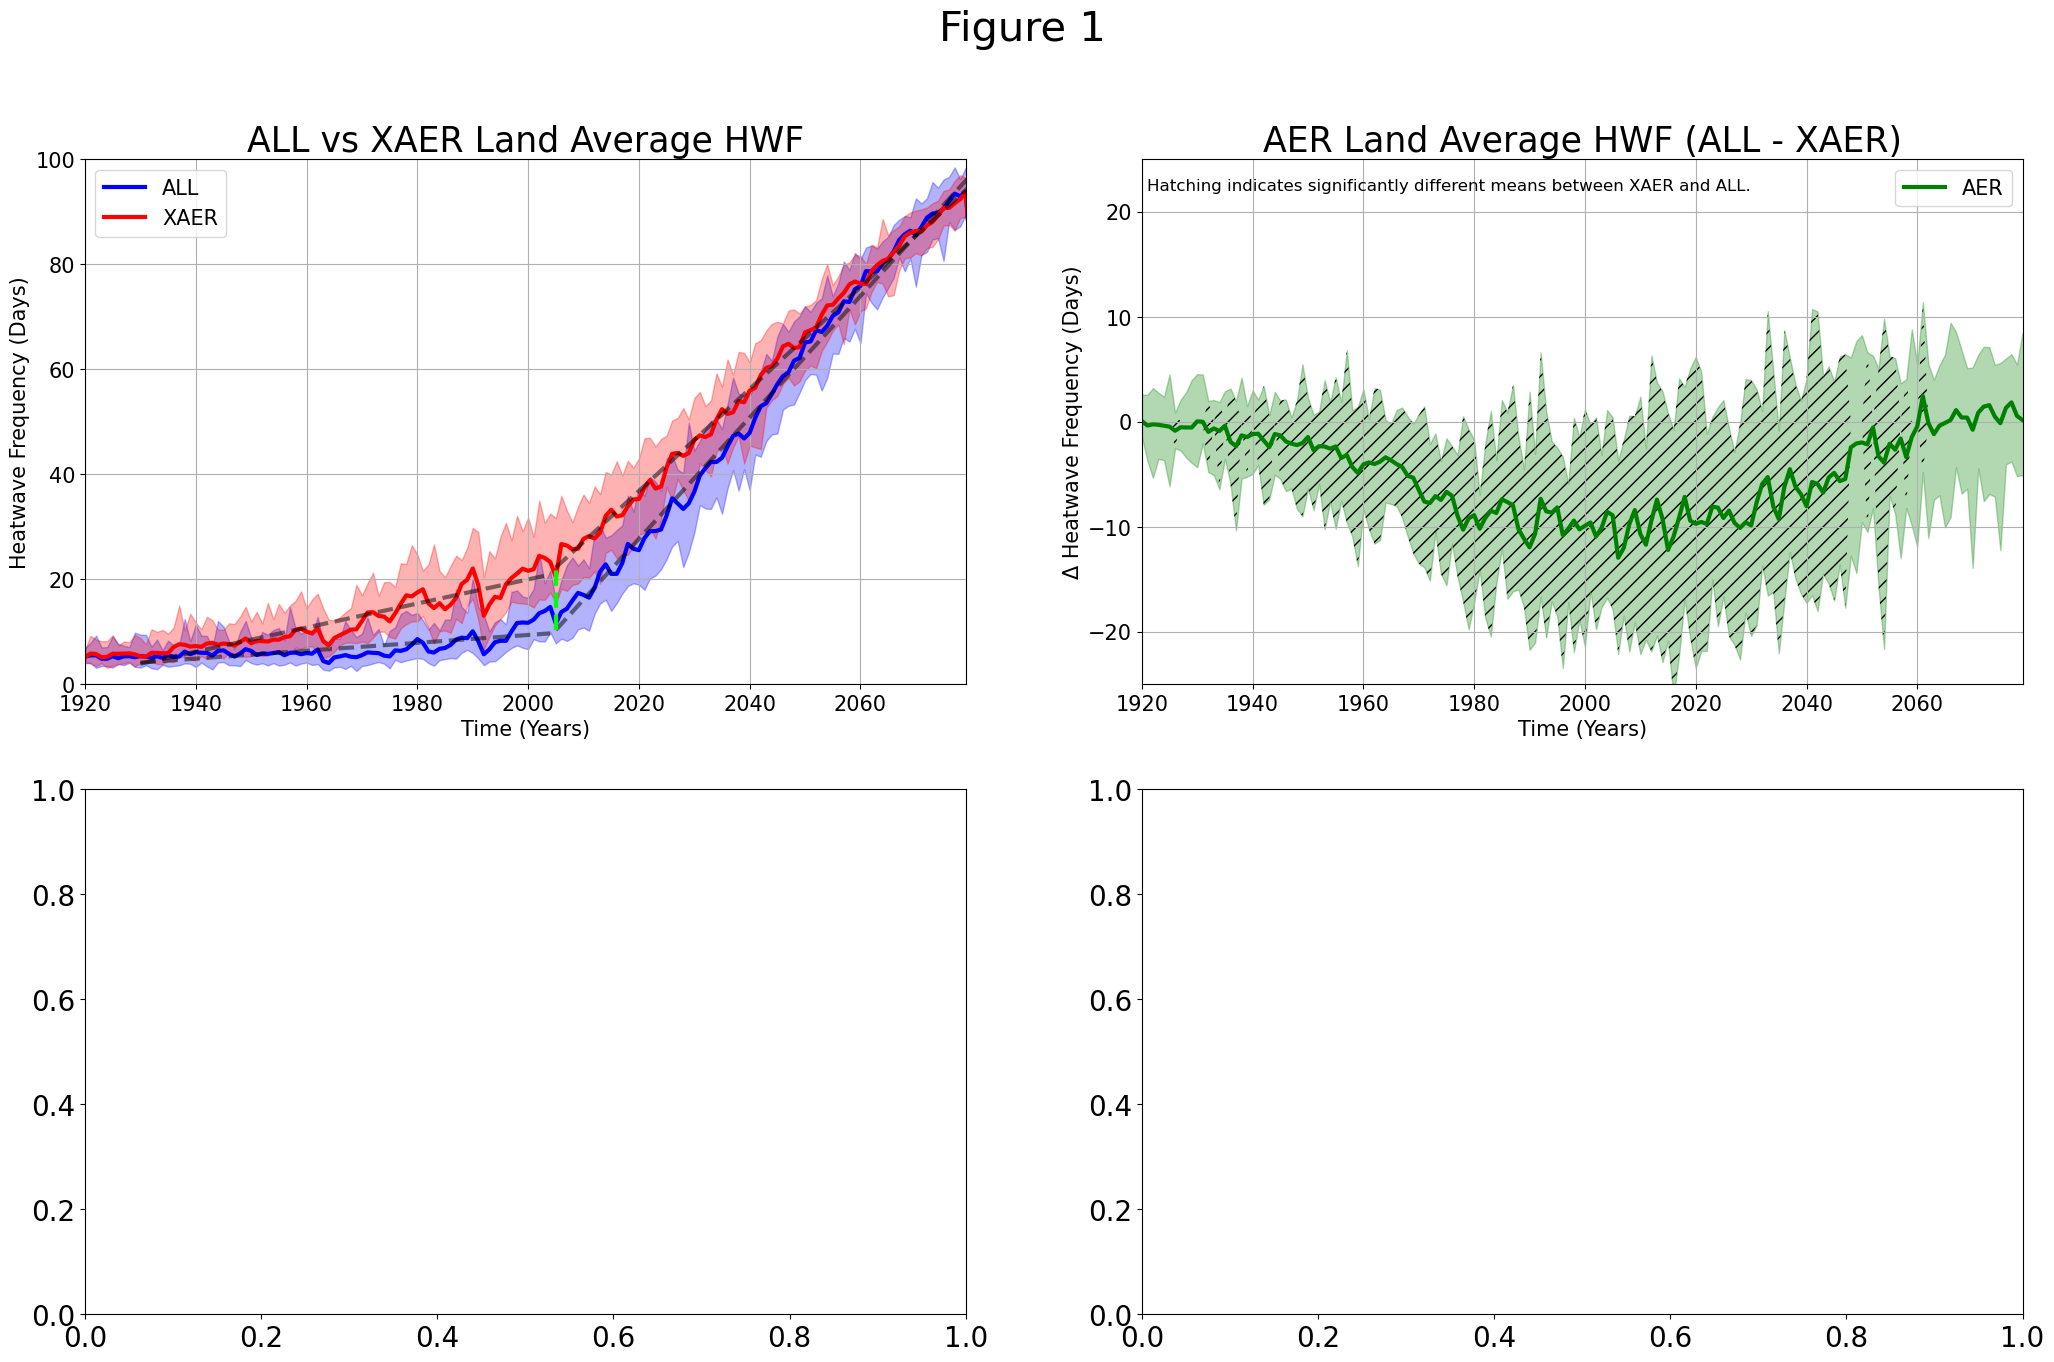

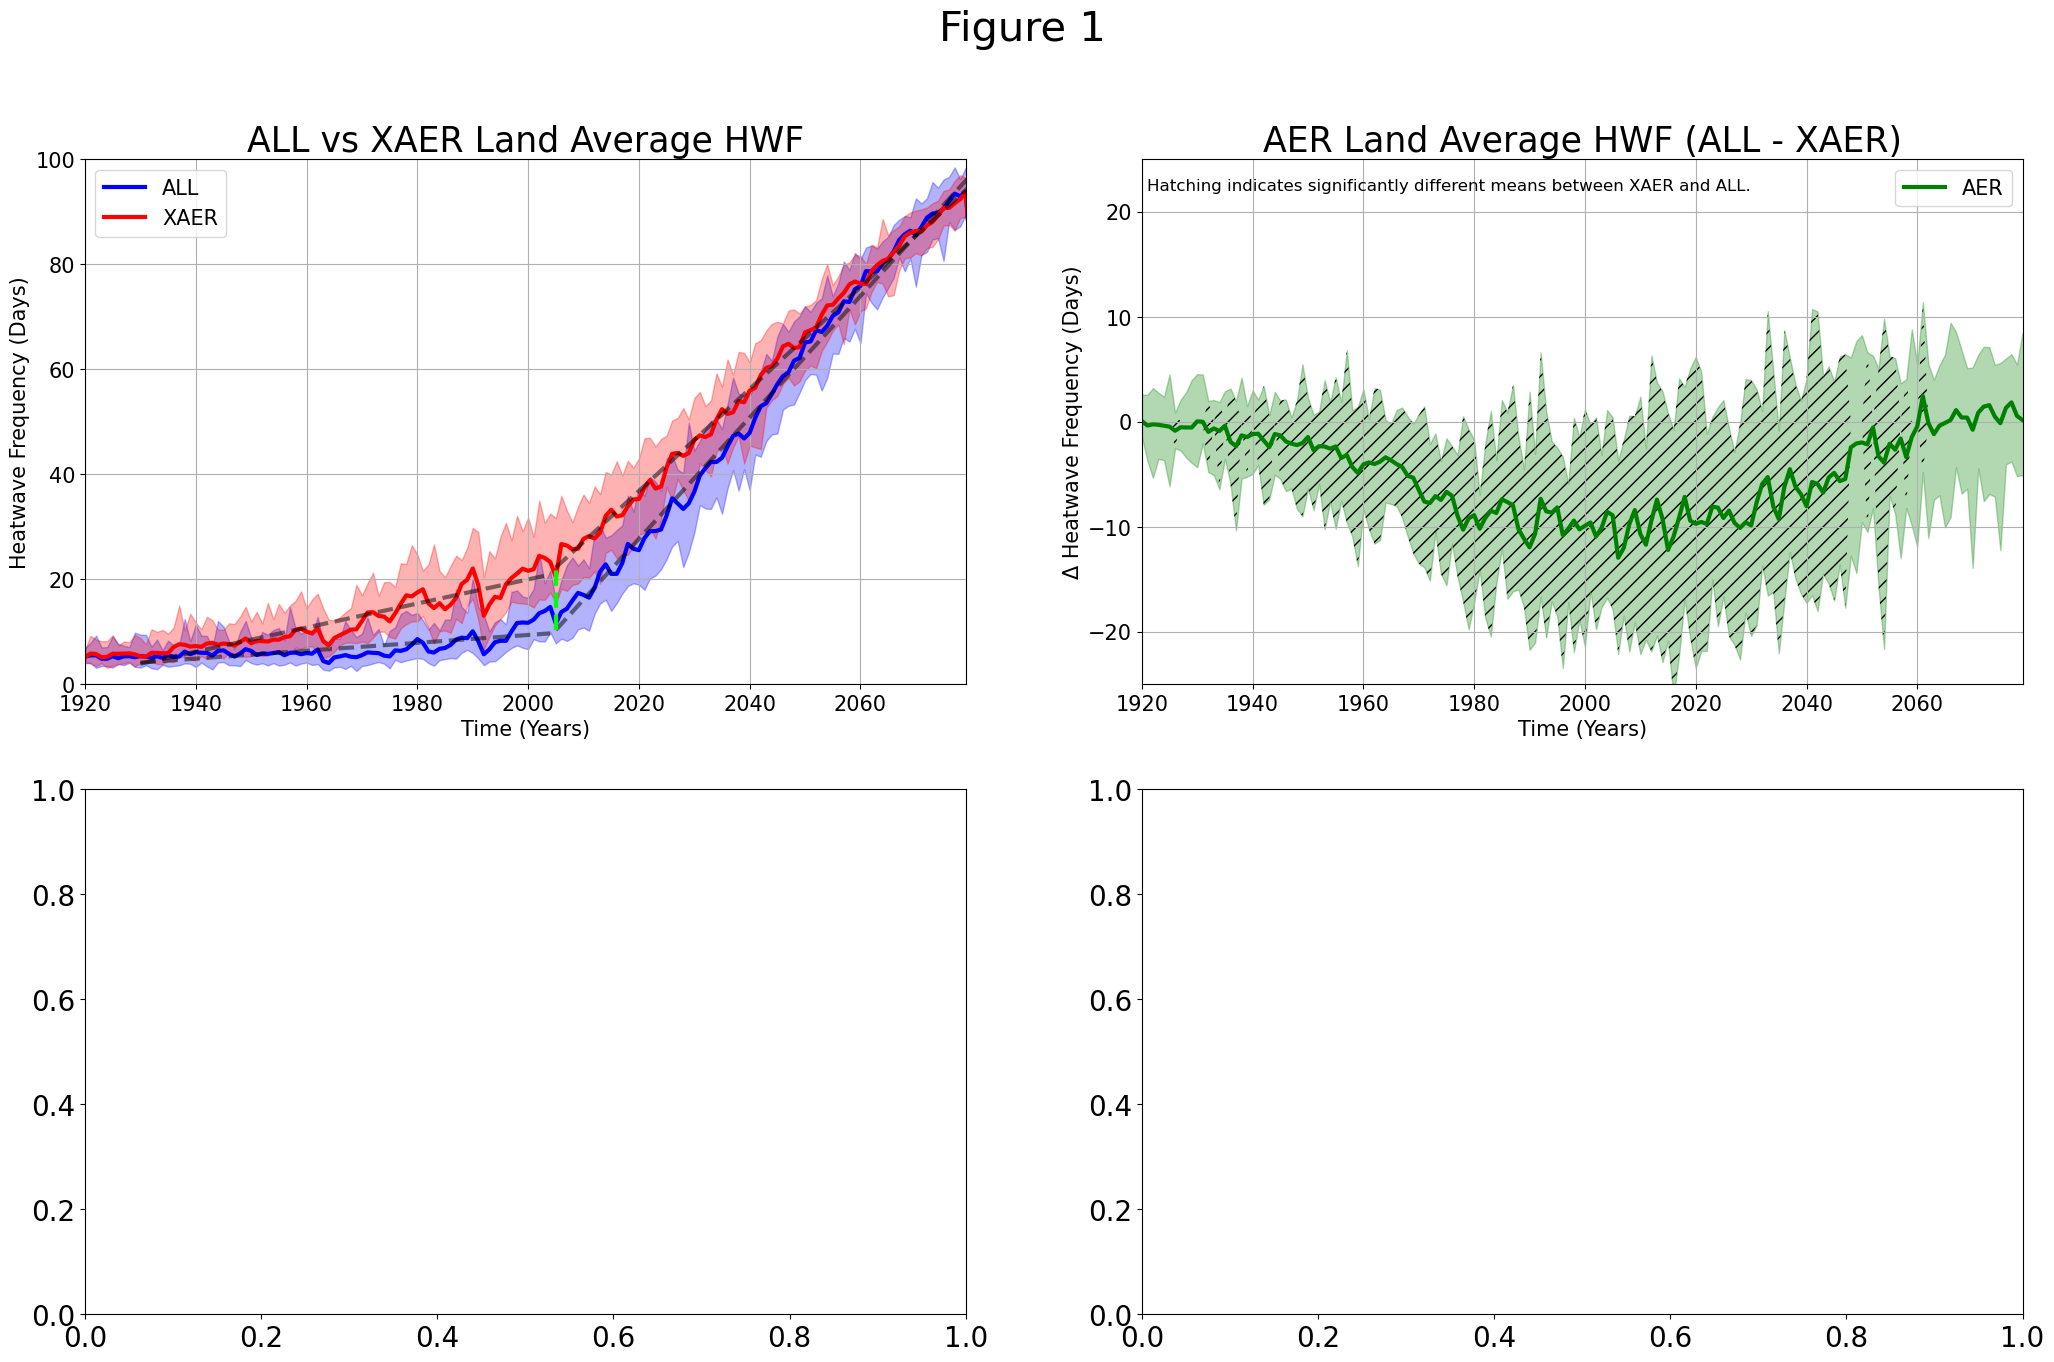

In [11]:
#rc('font', **{'size': 20})
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 15), facecolor='w')
f.suptitle("Figure 1", fontsize=30)

reg_index = 85

all_hwf_spatial_mavg.plot(ax=ax1, color="Blue", linewidth=3, label="ALL")
ax1.fill_between(all_hwf_spatial.year.values, all_hwf_spatial.min(dim="member"), all_hwf_spatial.max(dim="member"), color="Blue", alpha=0.3)
slope, inter, rval, pval, stderr = linregress(all_hwf_spatial_mavg.year.values[reg_index:], all_hwf_spatial_mavg.values[reg_index:])
ax1.plot(all_hwf_spatial_mavg.year.values[reg_index:], slope*all_hwf_spatial_mavg.year.values[reg_index:] + inter, linestyle="--", color="Black", linewidth=3, alpha=0.5)
#ax1.text(2030, 22, '{0:.{1}f} Days/Year'.format(slope, 2), color="Blue")

hslope, hinter, rval, pval, stderr = linregress(all_hwf_spatial_mavg.year.values[10:reg_index], all_hwf_spatial_mavg.values[10:reg_index])
ax1.plot(all_hwf_spatial_mavg.year.values[10:reg_index], hslope*all_hwf_spatial_mavg.year.values[10:reg_index] + hinter, linestyle="--", color="Black", linewidth=3, alpha=0.5)
#ax1.text(1922, 22, '{0:.{1}f} Days/Year'.format(hslope, 2), color="Blue")


xaer_hwf_spatial_mavg.plot(ax=ax1, color="Red", linewidth=3, label="XAER")
ax1.fill_between(xaer_hwf_spatial.year.values, xaer_hwf_spatial.min(dim="member"), xaer_hwf_spatial.max(dim="member"), color="Red", alpha=0.3)
xslope, xinter, rval, pval, stderr = linregress(xaer_hwf_spatial_mavg.year.values[reg_index:], xaer_hwf_spatial_mavg.values[reg_index:])
ax1.plot(xaer_hwf_spatial_mavg.year.values[reg_index:], xslope*xaer_hwf_spatial_mavg.year.values[reg_index:] + xinter, linestyle="--", color="Black", linewidth=3, alpha=0.5)
#ax1.text(1980, 45, '{0:.{1}f} Days/Year'.format(xslope, 2), color="Red")

ax1.plot([xaer_hwf_spatial_mavg.year.values[reg_index], xaer_hwf_spatial_mavg.year.values[reg_index]], [inter + 2005*slope, xinter + 2005*xslope], color="lime", linestyle="--", linewidth=3)
#ax1.text(2010, 5, '{0:.{1}f} Days'.format(abs(inter + 2005*slope - (xinter + 2005*xslope)), 2), color="limegreen")

xhslope, xhinter, rval, pval, stderr = linregress(xaer_hwf_spatial_mavg.year.values[10:reg_index], xaer_hwf_spatial_mavg.values[10:reg_index])
ax1.plot(xaer_hwf_spatial_mavg.year.values[10:reg_index], xhslope*xaer_hwf_spatial_mavg.year.values[10:reg_index] + xhinter, linestyle="--", color="Black", linewidth=3, alpha=0.5)
#ax1.text(1922, 32, '{0:.{1}f} Days/Year'.format(xhslope, 2), color="Red")


t_value, p_value = ttest_ind(xaer_hwf_spatial, all_hwf_spatial, equal_var=False)
(all_hwf_spatial_mavg - xaer_hwf_spatial_mavg).plot(ax=ax2, color="Green", linewidth=3, label="AER")
ax2.fill_between(xaer_hwf_spatial.year.values, (all_hwf_spatial - xaer_hwf_spatial).min(dim="member"), (all_hwf_spatial - xaer_hwf_spatial).max(dim="member"), color="Green", alpha=0.3)
ax2.fill_between(xaer_hwf_spatial.year.values, (all_hwf_spatial - xaer_hwf_spatial).min(dim="member")*(p_value < 0.05), (all_hwf_spatial - xaer_hwf_spatial).max(dim="member")*(p_value < 0.05), hatch="//", alpha=0)
ax2.text(1921, 22, "Hatching indicates significantly different means between XAER and ALL.", fontsize=12)

ax1.set_ylabel("Heatwave Frequency (Days)", fontsize=15)
ax1.set_xlabel("Time (Years)", fontsize=15)

ax1.set_title("ALL vs XAER Land Average HWF", fontsize=25)
ax1.legend(fontsize=15)
ax1.grid()
ax1.set_xlim(all_hwf_spatial_mavg.year.values[0], all_hwf_spatial_mavg.year.values[-1])
ax1.set_ylim(0, 100)
ax1.set_xlim(1920, 2079)

ax2.set_ylabel("Δ Heatwave Frequency (Days)", fontsize=15)
ax2.set_xlabel("Time (Years)", fontsize=15)

ax2.set_title("AER Land Average HWF (ALL - XAER)", fontsize=25)
ax2.legend(fontsize=15)
ax2.grid()
ax2.set_xlim(all_hwf_spatial_mavg.year.values[0], all_hwf_spatial_mavg.year.values[-1])
ax2.set_ylim(-25, 25)
ax2.set_xlim(1920, 2079)

ax1.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

# all_y_spatial_mavg.plot(ax=ax3, color="Blue", linewidth=3, label="ALL")
# ax3.fill_between(all_y_spatial.time.values, all_y_spatial.min(dim="member"), all_y_spatial.max(dim="member"), color="Blue", alpha=0.3)
# ax3.set_xlim(all_y_spatial.time.values[0], all_y_spatial.time.values[-2])

# xaer_y_spatial_mavg.plot(ax=ax3, color="Red", linewidth=3, label="XAER")
# ax3.fill_between(xaer_y_spatial.time.values, xaer_y_spatial.min(dim="member"), xaer_y_spatial.max(dim="member"), color="Red", alpha=0.3)
# ax3.set_xlim(xaer_y_spatial.time.values[0], xaer_y_spatial.time.values[-2])

# ax3.plot(all_y_spatial.time.values, np.ones(all_y_spatial.time.values.size)*control_y_spatial.values, color="Green", linestyle="--", linewidth=3, label="PIC")

# ax3.set_ylabel("Temperature (°C)", fontsize=15)
# ax3.set_xlabel("Time (Years)", fontsize=15)

# ax3.set_title("ALL vs XAER vs PIC Land Average TREFHTMN", fontsize=25)
# ax3.legend(fontsize=15)
# ax3.grid()
# ax3.set_xlim(all_y_spatial.time.values[0], all_y_spatial.time.values[-1])
# ax3.set_ylim(-4, 4)

f

In [6]:
coslat = np.cos(np.deg2rad(all_hwf_full.lat))
lat_weight = coslat / coslat.mean(dim='lat')

all_hwf_fut_spatial_slopes = all_hwf_full.sel(year=slice(2005, 2080)).where(landfrac > 0).mean(dim="member")
xaer_hwf_fut_spatial_slopes = xaer_hwf_full.sel(year=slice(2005, 2080)).where(landfrac > 0).mean(dim="member")
aer_hwf_fut_spatial_slopes = all_hwf_fut_spatial_slopes - xaer_hwf_fut_spatial_slopes


all_hwf_hist_spatial_slopes = all_hwf_full.sel(year=slice(1930, 2005)).where(landfrac > 0).mean(dim="member")
xaer_hwf_hist_spatial_slopes = xaer_hwf_full.sel(year=slice(1930, 2005)).where(landfrac > 0).mean(dim="member")
aer_hwf_hist_spatial_slopes = all_hwf_hist_spatial_slopes - xaer_hwf_hist_spatial_slopes

def get_slopes(ds):
    ret = np.zeros((ds.shape[1], ds.shape[2]))
    for i in range(ds.shape[1]):
        for j in range(ds.shape[2]):
            slope, inter, rval, pval, stderr = linregress(np.arange(ds.shape[0]), ds[:, i, j])
            ret[i, j] = slope
    return ret

hist_slopes = get_slopes(aer_hwf_hist_spatial_slopes.values)
fut_slopes = get_slopes(aer_hwf_fut_spatial_slopes.values)

aer_hwf_hist_spatial_slopes = aer_hwf_hist_spatial_slopes.mean(dim="year").rename("Heatwave Frequency Slope (Δ HWF/Year)")
aer_hwf_hist_spatial_slopes.values = hist_slopes
aer_hwf_fut_spatial_slopes = aer_hwf_fut_spatial_slopes.mean(dim="year").rename("Heatwave Frequency Slope (Δ HWF/Year)")
aer_hwf_fut_spatial_slopes.values = fut_slopes

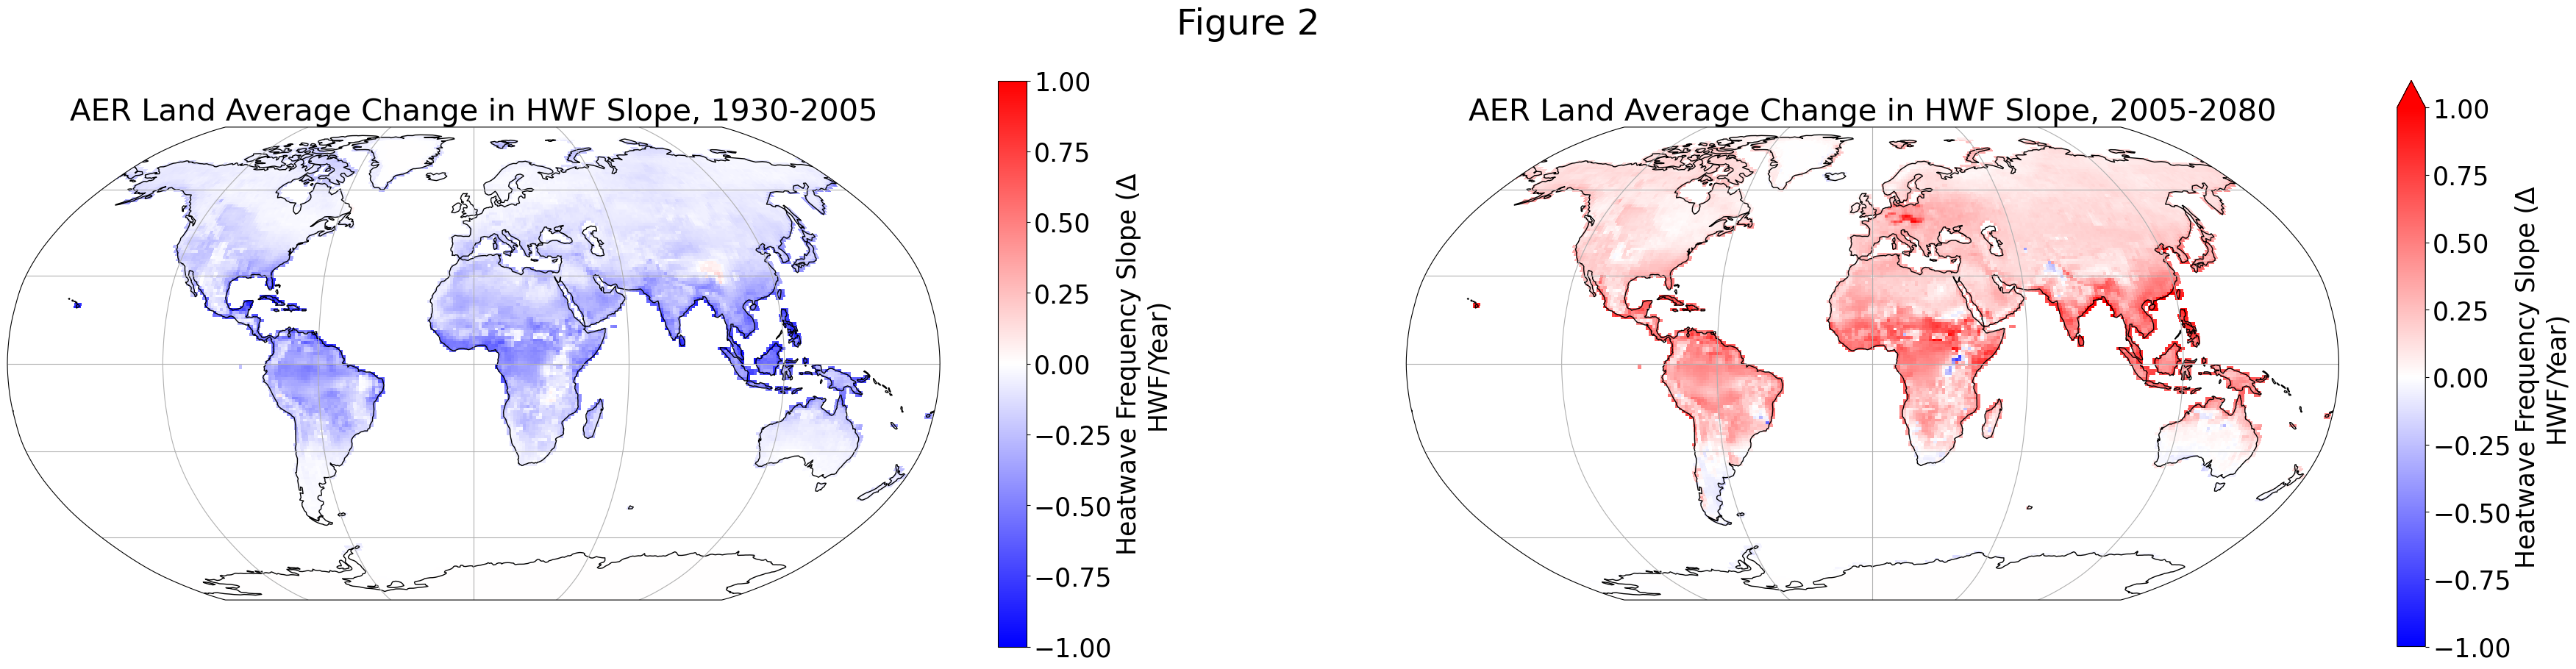

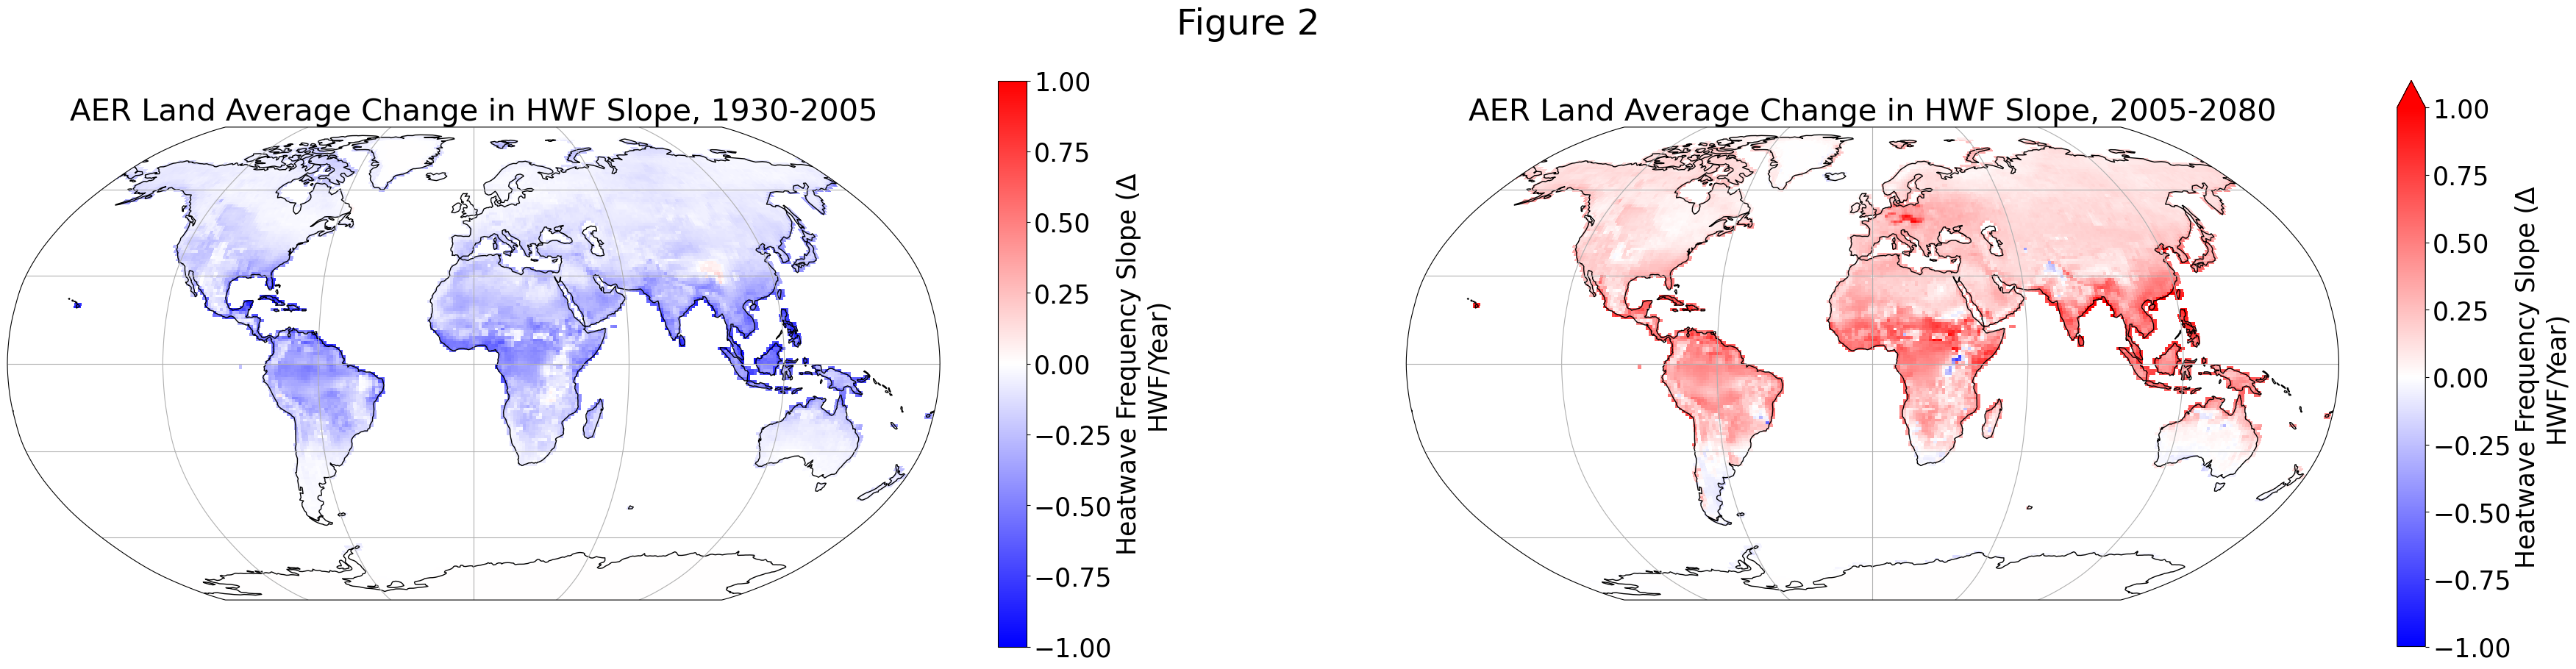

In [8]:
import cartopy.crs as ccrs
rc('font', **{'size': 25})

proj = ccrs.Robinson()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(45, 10), facecolor='w', subplot_kw=dict(projection=proj))
f.suptitle(f"Figure 2", fontsize=35)

aer_hwf_hist_spatial_slopes.plot(ax=ax1, cmap="bwr", vmin=-1, vmax=1, transform=ccrs.PlateCarree())
aer_hwf_fut_spatial_slopes.plot(ax=ax2, cmap="bwr", vmin=-1, vmax=1, transform=ccrs.PlateCarree())

ax1.coastlines()
ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)

ax2.coastlines()
ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)

ax1.set_title("AER Land Average Change in HWF Slope, 1930-2005")
ax2.set_title("AER Land Average Change in HWF Slope, 2005-2080")

f

In [9]:
all_1961_1990_avg = all_hwf_full.sel(year=slice(1961, 1990)).where(landfrac > 0).mean(dim="year").load()
xaer_1961_1990_avg = xaer_hwf_full.sel(year=slice(1961, 1990)).where(landfrac > 0).mean(dim="year").load()

all_1961_1990_m = all_hwf_full.sel(year=slice(1961, 1990)).where(landfrac > 0).mean(dim="member").load()
xaer_1961_1990_m = xaer_hwf_full.sel(year=slice(1961, 1990)).where(landfrac > 0).mean(dim="member").load()
aer_1961_1990_m = abs(all_1961_1990_m - xaer_1961_1990_m).sum(dim="year").where(landfrac > 0).rename("Heatwave Days (Days)")

all_2020_2049_m = all_hwf_full.sel(year=slice(2020, 2049)).where(landfrac > 0).mean(dim="member").load()
xaer_2020_2049_m = xaer_hwf_full.sel(year=slice(2020, 2049)).where(landfrac > 0).mean(dim="member").load()
aer_2020_2049_m = abs(all_2020_2049_m - xaer_2020_2049_m).sum(dim="year").where(landfrac > 0).rename("Heatwave Days (Days)")

all_1930_2005_m = all_hwf_full.sel(year=slice(1930, 2005)).where(landfrac > 0).mean(dim="member").load()
xaer_1930_2005_m = xaer_hwf_full.sel(year=slice(1930, 2005)).where(landfrac > 0).mean(dim="member").load()
aer_1930_2005_m = abs(all_1930_2005_m - xaer_1930_2005_m).sum(dim="year").where(landfrac > 0).rename("Heatwave Days (Days)")

all_2005_2080_m = all_hwf_full.sel(year=slice(2005, 2080)).where(landfrac > 0).mean(dim="member").load()
xaer_2005_2080_m = xaer_hwf_full.sel(year=slice(2005, 2080)).where(landfrac > 0).mean(dim="member").load()
aer_2005_2080_m = abs(all_2005_2080_m - xaer_2005_2080_m).sum(dim="year").where(landfrac > 0).rename("Heatwave Days (Days)")

all_1961_1990_mavg = all_1961_1990_avg.mean(dim="member").rename("Heatwave Frequency (Days)")
xaer_1961_1990_mavg = xaer_1961_1990_avg.mean(dim="member").rename("Heatwave Frequency (Days)")
aer_1961_1990_mavg = all_1961_1990_mavg - xaer_1961_1990_mavg
aer_1961_1990_mavg = aer_1961_1990_mavg.rename("Δ Heatwave Frequency (Days)")

all_2020_2049_avg = all_hwf_full.sel(year=slice(2020, 2049)).where(landfrac > 0).mean(dim="year").load()
xaer_2020_2049_avg = xaer_hwf_full.sel(year=slice(2020, 2049)).where(landfrac > 0).mean(dim="year").load()
all_2020_2049_mavg = all_2020_2049_avg.mean(dim="member").rename("Heatwave Frequency (Days)")
xaer_2020_2049_mavg = xaer_2020_2049_avg.mean(dim="member").rename("Heatwave Frequency (Days)")
aer_2020_2049_mavg = all_2020_2049_mavg - xaer_2020_2049_mavg
aer_2020_2049_mavg = aer_2020_2049_mavg.rename("Δ Heatwave Frequency (Days)")

all_1930_1960_avg = all_hwf_full.sel(year=slice(1930, 1960)).where(landfrac > 0).mean(dim="year").load()
xaer_1930_1960_avg = xaer_hwf_full.sel(year=slice(1930, 1960)).where(landfrac > 0).mean(dim="year").load()
all_1930_1960_mavg = all_1930_1960_avg.mean(dim="member").rename("Heatwave Frequency (Days)")
xaer_1930_1960_mavg = xaer_1930_1960_avg.mean(dim="member").rename("Heatwave Frequency (Days)")
aer_1930_1960_mavg = all_1930_1960_mavg - xaer_1930_1960_mavg
aer_1930_1960_mavg = aer_1930_1960_mavg.rename("Δ Heatwave Frequency (Days)")

all_1961_1990_avg = all_hwf_full.sel(year=slice(1961, 1990)).where(landfrac > 0).mean(dim="year").load()
xaer_1961_1990_avg = xaer_hwf_full.sel(year=slice(1961, 1990)).where(landfrac > 0).mean(dim="year").load()
all_1961_1990_mavg = all_1961_1990_avg.mean(dim="member").rename("Heatwave Frequency (Days)")
xaer_1961_1990_mavg = xaer_1961_1990_avg.mean(dim="member").rename("Heatwave Frequency (Days)")
aer_1961_1990_mavg = all_1961_1990_mavg - xaer_1961_1990_mavg
aer_1961_1990_mavg = aer_1961_1990_mavg.rename("Δ Heatwave Frequency (Days)")

all_2050_2080_avg = all_hwf_full.sel(year=slice(2050, 2080)).where(landfrac > 0).mean(dim="year").load()
xaer_2050_2080_avg = xaer_hwf_full.sel(year=slice(2050, 2080)).where(landfrac > 0).mean(dim="year").load()
all_2050_2080_mavg = all_2050_2080_avg.mean(dim="member").rename("Heatwave Frequency (Days)")
xaer_2050_2080_mavg = xaer_2050_2080_avg.mean(dim="member").rename("Heatwave Frequency (Days)")
aer_2050_2080_mavg = all_2050_2080_mavg - xaer_2050_2080_mavg
aer_2050_2080_mavg = aer_2050_2080_mavg.rename("Δ Heatwave Frequency (Days)")

sig_1961_1990 = sig_testing(all_hwf_full.sel(year=slice(1961, 1990)).where(landfrac > 0), xaer_hwf_full.sel(year=slice(1961, 1990)).where(landfrac > 0))
sig_1961_1990 = sig_1961_1990.where(sig_1961_1990 > 0.05)

sig_2020_2049 = sig_testing(all_hwf_full.sel(year=slice(2020, 2049)).where(landfrac > 0), xaer_hwf_full.sel(year=slice(2020, 2049)).where(landfrac > 0))
sig_2020_2049 = sig_2020_2049.where(sig_2020_2049 > 0.05)

sig_1930_1960 = sig_testing(all_hwf_full.sel(year=slice(1930, 1960)).where(landfrac > 0), xaer_hwf_full.sel(year=slice(1930, 1960)).where(landfrac > 0))
sig_1930_1960 = sig_1930_1960.where(sig_1930_1960 > 0.05)

sig_1961_1990 = sig_testing(all_hwf_full.sel(year=slice(1961, 1990)).where(landfrac > 0), xaer_hwf_full.sel(year=slice(1961, 1990)).where(landfrac > 0))
sig_1961_1990 = sig_1961_1990.where(sig_1961_1990 > 0.05)

sig_2050_2080 = sig_testing(all_hwf_full.sel(year=slice(2050, 2080)).where(landfrac > 0), xaer_hwf_full.sel(year=slice(2050, 2080)).where(landfrac > 0))
sig_2050_2080 = sig_2050_2080.where(sig_2050_2080 > 0.05)

In [ ]:
import cartopy.crs as ccrs
from matplotlib import rc

/home/jupyterhub/miniconda-persad/envs/lab/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jupyterhub/miniconda-persad/envs/lab/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/jupyterhub/miniconda-persad/envs/lab/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jupyterhub/miniconda-persad/envs/lab/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/jupyterhub/miniconda-persad/envs/lab/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jupyterhub/miniconda-persa

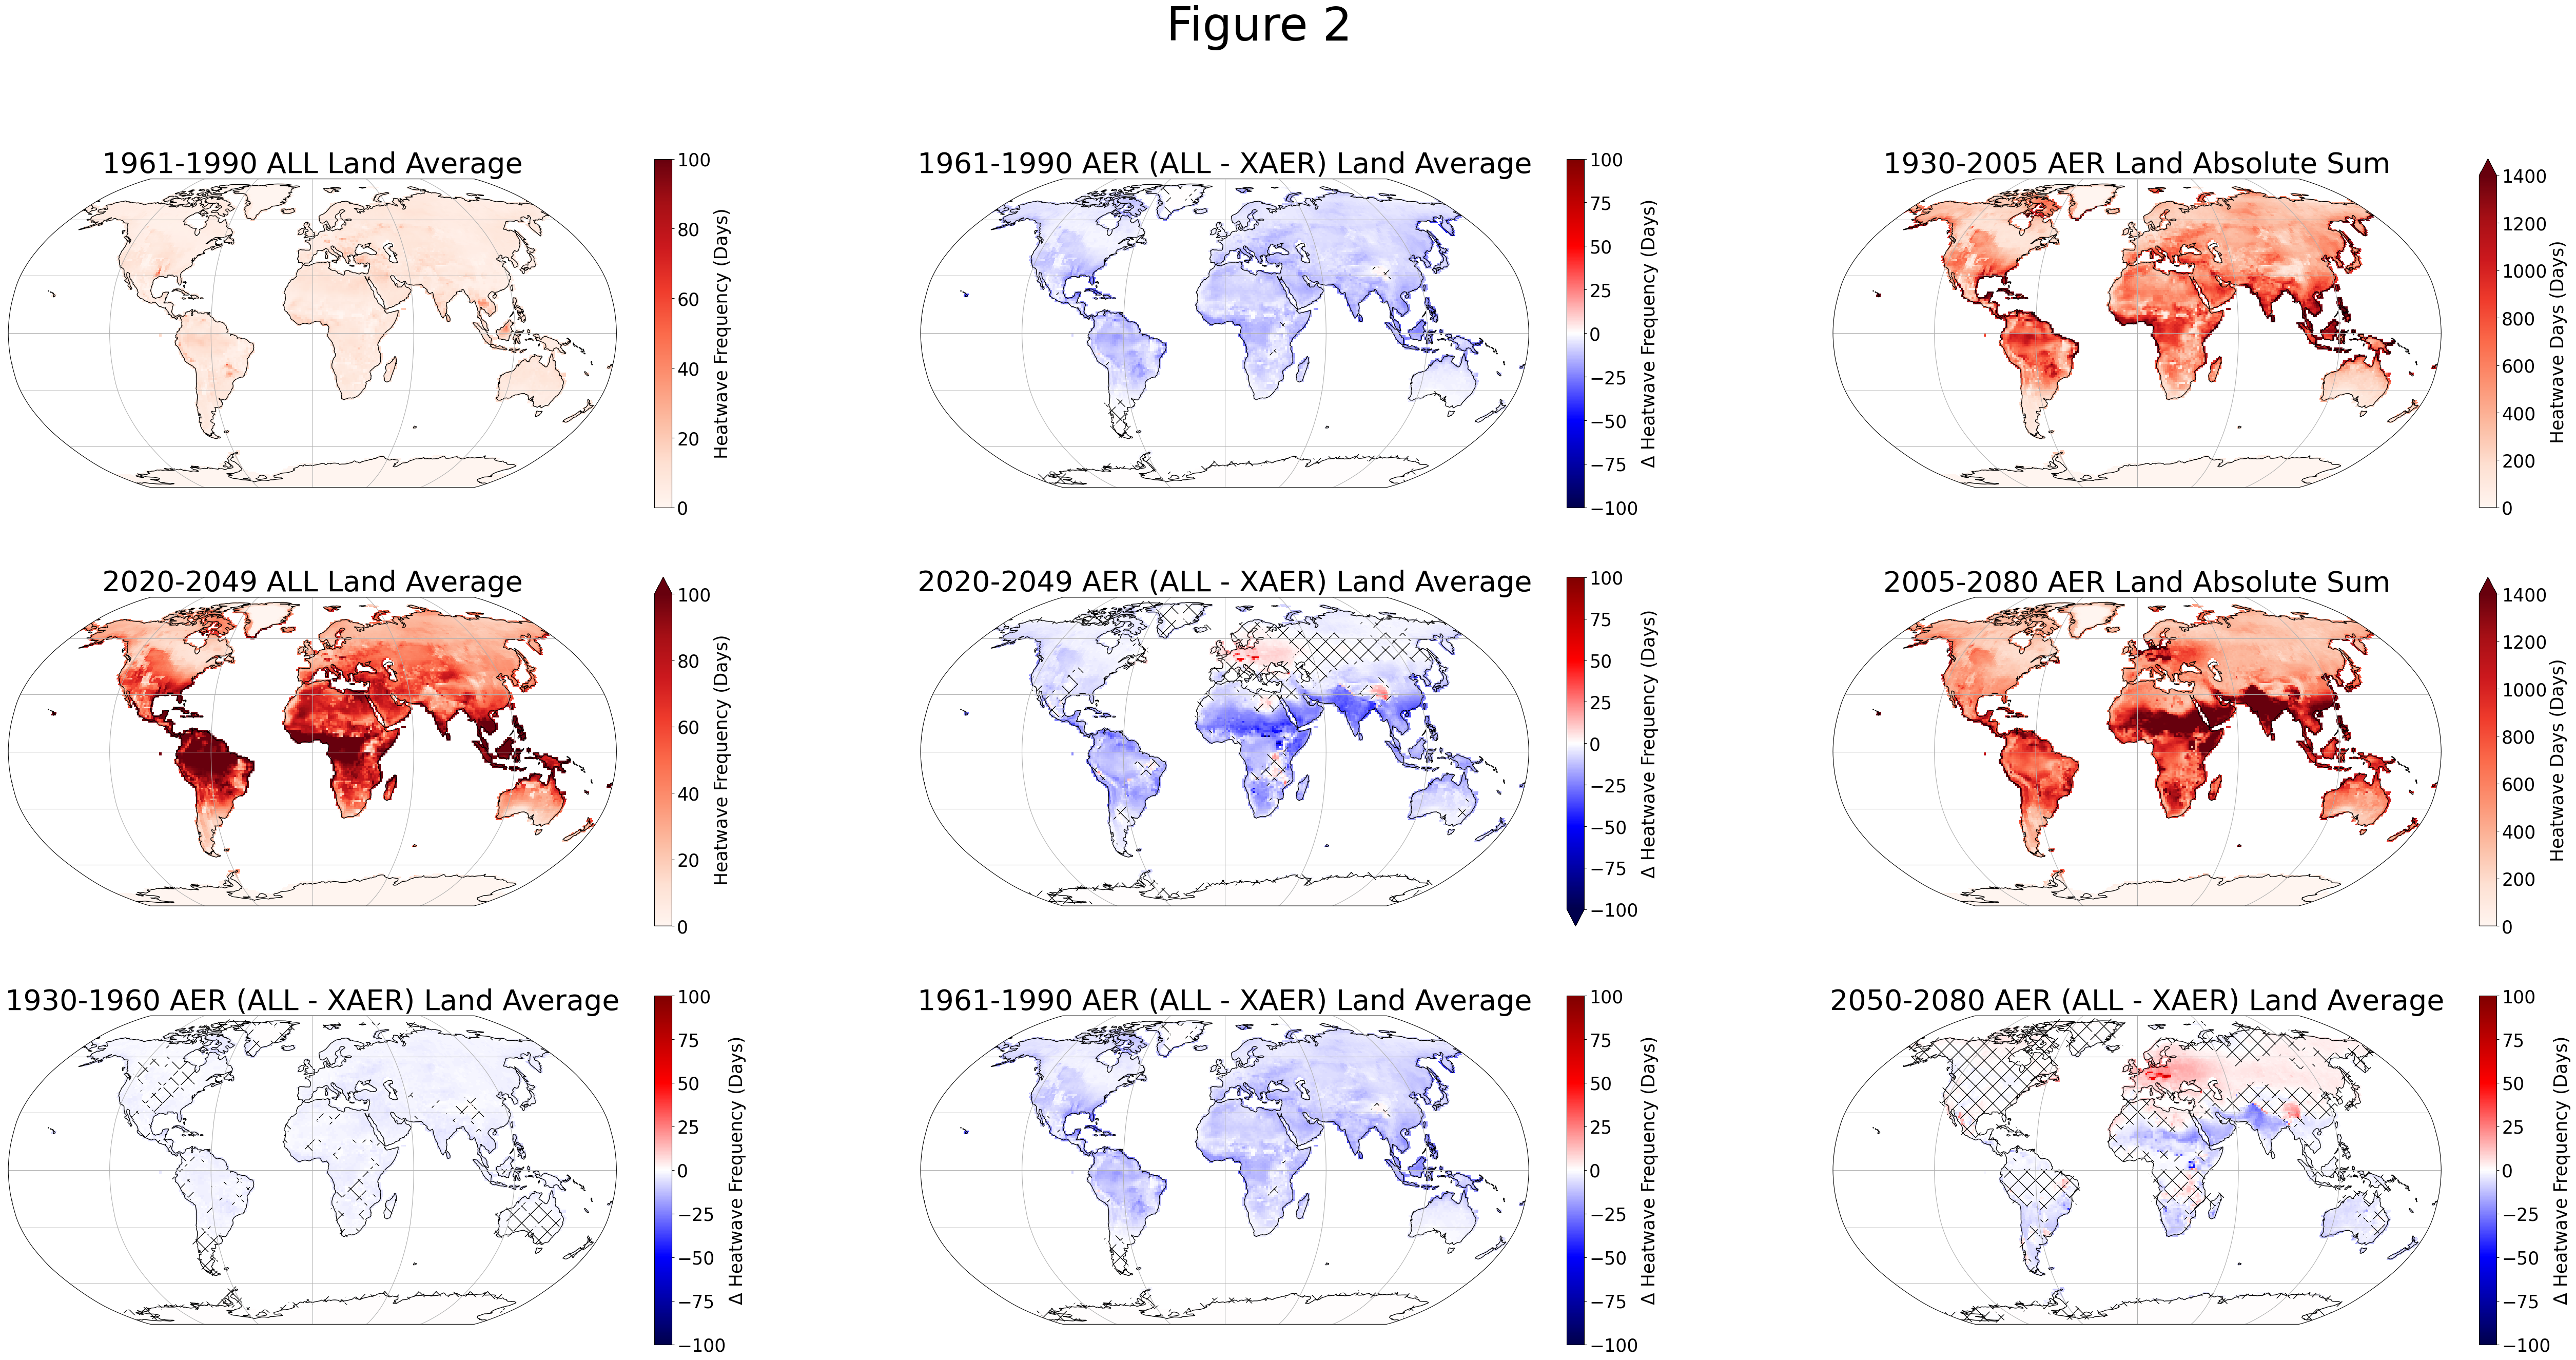

In [10]:
import cartopy.crs as ccrs
from matplotlib import rc

rc('font', **{'size': 25})
proj = ccrs.Robinson()
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(65, 30), facecolor='w', subplot_kw=dict(projection=proj))

f.suptitle(f"Figure 2", fontsize=65)

vmin=-100
vmax=100
cmap = "seismic"

all_1961_1990_mavg.plot(ax=ax1, cmap="Reds", vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
aer_1961_1990_mavg.plot(ax=ax2, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
aer_1930_2005_m.plot(ax=ax3, cmap="Reds", vmin=0, vmax=1400, transform=ccrs.PlateCarree())

all_2020_2049_mavg.plot(ax=ax4, cmap="Reds", vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
aer_2020_2049_mavg.plot(ax=ax5, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
aer_2005_2080_m.plot(ax=ax6, cmap="Reds", vmin=0, vmax=1400, transform=ccrs.PlateCarree())

aer_1930_1960_mavg.plot(ax=ax7, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
aer_1961_1990_mavg.plot(ax=ax8, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
aer_2050_2080_mavg.plot(ax=ax9, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())


X, Y = np.meshgrid(sig_1961_1990.lon, sig_1961_1990.lat)
ax2.hexbin(X.reshape(-1), Y.reshape(-1), sig_1961_1990.data.reshape(-1), hatch='x', alpha=0, transform=ccrs.PlateCarree())
ax5.hexbin(X.reshape(-1), Y.reshape(-1), sig_2020_2049.data.reshape(-1), hatch='x', alpha=0, transform=ccrs.PlateCarree())

ax7.hexbin(X.reshape(-1), Y.reshape(-1), sig_1930_1960.data.reshape(-1), hatch='x', alpha=0, transform=ccrs.PlateCarree())
ax8.hexbin(X.reshape(-1), Y.reshape(-1), sig_1961_1990.data.reshape(-1), hatch='x', alpha=0, transform=ccrs.PlateCarree())
ax9.hexbin(X.reshape(-1), Y.reshape(-1), sig_2050_2080.data.reshape(-1), hatch='x', alpha=0, transform=ccrs.PlateCarree())


fz = 40

ax1.set_title("1961-1990 ALL Land Average", fontsize=fz)
ax2.set_title("1961-1990 AER (ALL - XAER) Land Average", fontsize=fz)
ax3.set_title("1930-2005 AER Land Absolute Sum", fontsize=fz)

ax4.set_title("2020-2049 ALL Land Average", fontsize=fz)
ax5.set_title("2020-2049 AER (ALL - XAER) Land Average", fontsize=fz)
ax6.set_title("2005-2080 AER Land Absolute Sum", fontsize=fz)

ax7.set_title("1930-1960 AER (ALL - XAER) Land Average", fontsize=fz)
ax8.set_title("1961-1990 AER (ALL - XAER) Land Average", fontsize=fz)
ax9.set_title("2050-2080 AER (ALL - XAER) Land Average", fontsize=fz)


ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()
ax5.coastlines()
ax6.coastlines()
ax7.coastlines()
ax8.coastlines()
ax9.coastlines()

ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
ax7.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
ax8.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
ax9.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)

In [ ]:
landfrac

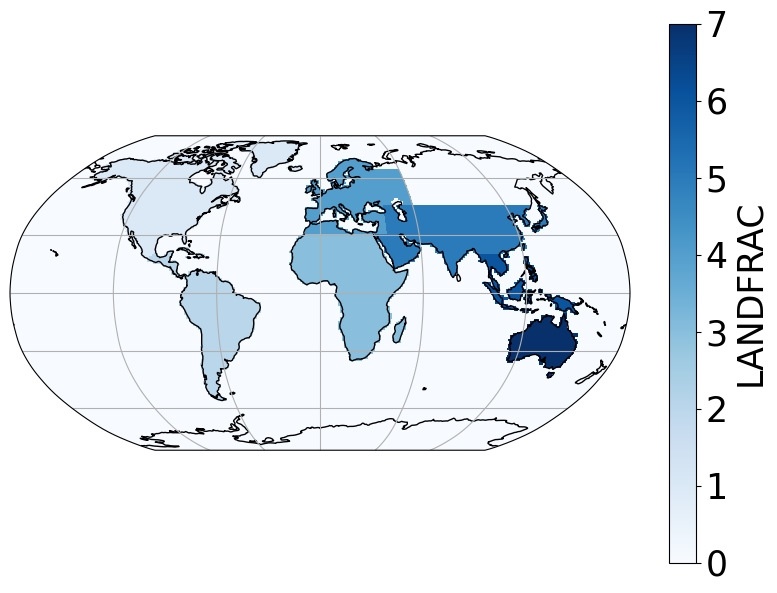

In [11]:
landfrac = xarray.open_dataset(HEAD_DIR + "LANDFRAC/DOWNLOAD/b.e11.B1850C5CN.f09_g16.005.cam.h0.LANDFRAC.040001-049912.nc")["LANDFRAC"].mean(dim="time")

ar6_mask = regionmask.defined_regions.ar6.land.mask(landfrac.lon, landfrac.lat)

graphic = landfrac.copy()*0
graphic.values += (landfrac.where(landfrac > 0).where(ar6_mask <= 6).fillna(0).values > 0)*1
graphic.values += (landfrac.where(landfrac > 0).where(ar6_mask <= 15).where(ar6_mask >= 7).fillna(0).values > 0)*2
graphic.values += (landfrac.where(landfrac > 0).where(ar6_mask <= 27).where(ar6_mask >= 20).fillna(0).values > 0)*3
graphic.values += (landfrac.where(landfrac > 0).where(ar6_mask <= 19).where(ar6_mask >= 16).fillna(0).values > 0)*4
graphic.values += (landfrac.where(landfrac > 0).where(ar6_mask <= 37).where(ar6_mask >= 32).fillna(0).values > 0)*5
graphic.values += (landfrac.where(landfrac > 0).where(ar6_mask == 38).fillna(0).values > 0)*6
graphic.values += (landfrac.where(landfrac > 0).where(ar6_mask <= 42).where(ar6_mask >= 39).fillna(0).values > 0)*7

proj = ccrs.Robinson()
f, ax1 = plt.subplots(1, 1, figsize=(10, 7), facecolor='w', subplot_kw=dict(projection=proj))

graphic.plot(ax=ax1, transform=ccrs.PlateCarree(), linewidths=1, cmap="Blues")

ax1.coastlines()
ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)


In [12]:
all_na = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 6).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")
all_csa = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 15).where(ar6_mask >= 7).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")
all_af = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 27).where(ar6_mask >= 20).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")
all_euro = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 19).where(ar6_mask >= 16).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")
all_sa = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 37).where(ar6_mask >= 32).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")
all_oc = all_hwf_full.where(landfrac > 0).where(ar6_mask == 38).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")
all_au = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 42).where(ar6_mask >= 39).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")

xaer_na = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 6).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")
xaer_csa = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 15).where(ar6_mask >= 7).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")
xaer_af = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 27).where(ar6_mask >= 20).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")
xaer_euro = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 19).where(ar6_mask >= 16).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")
xaer_sa = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 37).where(ar6_mask >= 32).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")
xaer_oc = xaer_hwf_full.where(landfrac > 0).where(ar6_mask == 38).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")
xaer_au = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 42).where(ar6_mask >= 39).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")

aer_na = all_na - xaer_na
aer_csa = all_csa - xaer_csa
aer_af = all_af - xaer_af
aer_euro = all_euro - xaer_euro
aer_sa = all_sa - xaer_sa
aer_oc = all_oc - xaer_oc
aer_au = all_au - xaer_au

In [13]:
all_std_na = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 6).weighted(lat_weight).mean(dim="lat").mean(dim="lon").std(dim="member")
all_std_csa = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 15).where(ar6_mask >= 7).weighted(lat_weight).mean(dim="lat").mean(dim="lon").std(dim="member")
all_std_af = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 27).where(ar6_mask >= 20).weighted(lat_weight).mean(dim="lat").mean(dim="lon").std(dim="member")
all_std_euro = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 19).where(ar6_mask >= 16).weighted(lat_weight).mean(dim="lat").mean(dim="lon").std(dim="member")
all_std_sa = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 37).where(ar6_mask >= 32).weighted(lat_weight).mean(dim="lat").mean(dim="lon").std(dim="member")
all_std_oc = all_hwf_full.where(landfrac > 0).where(ar6_mask == 38).weighted(lat_weight).mean(dim="lat").mean(dim="lon").std(dim="member")
all_std_au = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 42).where(ar6_mask >= 39).weighted(lat_weight).mean(dim="lat").mean(dim="lon").std(dim="member")

xaer_std_na = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 6).weighted(lat_weight).mean(dim="lat").mean(dim="lon").std(dim="member")
xaer_std_csa = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 15).where(ar6_mask >= 7).weighted(lat_weight).mean(dim="lat").mean(dim="lon").std(dim="member")
xaer_std_af = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 27).where(ar6_mask >= 20).weighted(lat_weight).mean(dim="lat").mean(dim="lon").std(dim="member")
xaer_std_euro = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 19).where(ar6_mask >= 16).weighted(lat_weight).mean(dim="lat").mean(dim="lon").std(dim="member")
xaer_std_sa = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 37).where(ar6_mask >= 32).weighted(lat_weight).mean(dim="lat").mean(dim="lon").std(dim="member")
xaer_std_oc = xaer_hwf_full.where(landfrac > 0).where(ar6_mask == 38).weighted(lat_weight).mean(dim="lat").mean(dim="lon").std(dim="member")
xaer_std_au = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 42).where(ar6_mask >= 39).weighted(lat_weight).mean(dim="lat").mean(dim="lon").std(dim="member")

aer_std_na = np.power((all_std_na**2 / all_hwf_full.shape[0]) + (xaer_std_na**2 / xaer_hwf_full.shape[0]), 0.5)
aer_std_csa = np.power((all_std_csa**2 / all_hwf_full.shape[0]) + (xaer_std_csa**2 / xaer_hwf_full.shape[0]), 0.5)
aer_std_af = np.power((all_std_af**2 / all_hwf_full.shape[0]) + (xaer_std_af**2 / xaer_hwf_full.shape[0]), 0.5)
aer_std_euro = np.power((all_std_euro**2 / all_hwf_full.shape[0]) + (xaer_std_euro**2 / xaer_hwf_full.shape[0]), 0.5)
aer_std_sa = np.power((all_std_sa**2 / all_hwf_full.shape[0]) + (xaer_std_sa**2 / xaer_hwf_full.shape[0]), 0.5)
aer_std_oc = np.power((all_std_oc**2 / all_hwf_full.shape[0]) + (xaer_std_oc**2 / xaer_hwf_full.shape[0]), 0.5)
aer_std_au = np.power((all_std_au**2 / all_hwf_full.shape[0]) + (xaer_std_au**2 / xaer_hwf_full.shape[0]), 0.5)

In [14]:
reg_index = 85
all_na_fut_m, all_na_fut_b, rval, pval, stderr = linregress(all_na.year.values[reg_index:], all_na.values[reg_index:])
all_csa_fut_m, all_csa_fut_b, rval, pval, stderr = linregress(all_csa.year.values[reg_index:], all_csa.values[reg_index:])
all_af_fut_m, all_af_fut_b, rval, pval, stderr = linregress(all_af.year.values[reg_index:], all_af.values[reg_index:])
all_euro_fut_m, all_euro_fut_b, rval, pval, stderr = linregress(all_euro.year.values[reg_index:], all_euro.values[reg_index:])
all_sa_fut_m, all_sa_fut_b, rval, pval, stderr = linregress(all_sa.year.values[reg_index:], all_sa.values[reg_index:])
all_oc_fut_m, all_oc_fut_b, rval, pval, stderr = linregress(all_oc.year.values[reg_index:], all_oc.values[reg_index:])
all_au_fut_m, all_au_fut_b, rval, pval, stderr = linregress(all_au.year.values[reg_index:], all_au.values[reg_index:])

all_na_past_m, all_na_past_b, rval, pval, stderr = linregress(all_na.year.values[:reg_index], all_na.values[:reg_index])
all_csa_past_m, all_csa_past_b, rval, pval, stderr = linregress(all_csa.year.values[:reg_index], all_csa.values[:reg_index])
all_af_past_m, all_af_past_b, rval, pval, stderr = linregress(all_af.year.values[:reg_index], all_af.values[:reg_index])
all_euro_past_m, all_euro_past_b, rval, pval, stderr = linregress(all_euro.year.values[:reg_index], all_euro.values[:reg_index])
all_sa_past_m, all_sa_past_b, rval, pval, stderr = linregress(all_sa.year.values[:reg_index], all_sa.values[:reg_index])
all_oc_past_m, all_oc_past_b, rval, pval, stderr = linregress(all_oc.year.values[:reg_index], all_oc.values[:reg_index])
all_au_past_m, all_au_past_b, rval, pval, stderr = linregress(all_au.year.values[:reg_index], all_au.values[:reg_index])

xaer_na_fut_m, xaer_na_fut_b, rval, pval, stderr = linregress(xaer_na.year.values[reg_index:], xaer_na.values[reg_index:])
xaer_csa_fut_m, xaer_csa_fut_b, rval, pval, stderr = linregress(xaer_csa.year.values[reg_index:], xaer_csa.values[reg_index:])
xaer_af_fut_m, xaer_af_fut_b, rval, pval, stderr = linregress(xaer_af.year.values[reg_index:], xaer_af.values[reg_index:])
xaer_euro_fut_m, xaer_euro_fut_b, rval, pval, stderr = linregress(xaer_euro.year.values[reg_index:], xaer_euro.values[reg_index:])
xaer_sa_fut_m, xaer_sa_fut_b, rval, pval, stderr = linregress(xaer_sa.year.values[reg_index:], xaer_sa.values[reg_index:])
xaer_oc_fut_m, xaer_oc_fut_b, rval, pval, stderr = linregress(xaer_oc.year.values[reg_index:], xaer_oc.values[reg_index:])
xaer_au_fut_m, xaer_au_fut_b, rval, pval, stderr = linregress(xaer_au.year.values[reg_index:], xaer_au.values[reg_index:])

xaer_na_past_m, xaer_na_past_b, rval, pval, stderr = linregress(xaer_na.year.values[:reg_index], xaer_na.values[:reg_index])
xaer_csa_past_m, xaer_csa_past_b, rval, pval, stderr = linregress(xaer_csa.year.values[:reg_index], xaer_csa.values[:reg_index])
xaer_af_past_m, xaer_af_past_b, rval, pval, stderr = linregress(xaer_af.year.values[:reg_index], xaer_af.values[:reg_index])
xaer_euro_past_m, xaer_euro_past_b, rval, pval, stderr = linregress(xaer_euro.year.values[:reg_index], xaer_euro.values[:reg_index])
xaer_sa_past_m, xaer_sa_past_b, rval, pval, stderr = linregress(xaer_sa.year.values[:reg_index], xaer_sa.values[:reg_index])
xaer_oc_past_m, xaer_oc_past_b, rval, pval, stderr = linregress(xaer_oc.year.values[:reg_index], xaer_oc.values[:reg_index])
xaer_au_past_m, xaer_au_past_b, rval, pval, stderr = linregress(xaer_au.year.values[:reg_index], xaer_au.values[:reg_index])

In [15]:
with open("Table1.csv", 'w') as f:
    n=2
    f.write(",NA,CSA,AF,EU,SA,OC,AU\n")
    f.write(f"ALL Slope (Days/Year),{np.round(all_na_fut_m, n)},{np.round(all_csa_fut_m, n)},{np.round(all_af_fut_m, n)},{np.round(all_euro_fut_m, n)},{np.round(all_sa_fut_m, n)},{np.round(all_oc_fut_m, n)},{np.round(all_au_fut_m, n)}\n")
    f.write(f"XAER Slope (Days/Year),{np.round(xaer_na_fut_m, n)},{np.round(xaer_csa_fut_m, n)},{np.round(xaer_af_fut_m, n)},{np.round(xaer_euro_fut_m, n)},{np.round(xaer_sa_fut_m, n)},{np.round(xaer_oc_fut_m, n)},{np.round(xaer_au_fut_m, n)}\n")
    f.write(f"ALL Intercept (Days),{np.round(all_na_fut_b, n)},{np.round(all_csa_fut_b, n)},{np.round(all_af_fut_b, n)},{np.round(all_euro_fut_b, n)},{np.round(all_sa_fut_b, n)},{np.round(all_oc_fut_b, n)},{np.round(all_au_fut_b, n)}\n")
    f.write(f"XAER Intercept (Days),{np.round(xaer_na_fut_b, n)},{np.round(xaer_csa_fut_b, n)},{np.round(xaer_af_fut_b, n)},{np.round(xaer_euro_fut_b, n)},{np.round(xaer_sa_fut_b, n)},{np.round(xaer_oc_fut_b, n)},{np.round(xaer_au_fut_b, n)}\n")
    d1 = all_na_fut_m - xaer_na_fut_m
    d2 = all_csa_fut_m - xaer_csa_fut_m
    d3 = all_af_fut_m - xaer_af_fut_m
    d4 = all_euro_fut_m - xaer_euro_fut_m
    d5 = all_sa_fut_m - xaer_sa_fut_m
    d6 = all_oc_fut_m - xaer_oc_fut_m
    d7 = all_au_fut_m - xaer_au_fut_m
    f.write(f"AER Δ Slope (Days/Year),{np.round(d1, n)},{np.round(d2, n)},{np.round(d3, n)},{np.round(d4, n)},{np.round(d5, n)},{np.round(d6, n)},{np.round(d7, n)}\n")
    d1 = all_na_fut_b - xaer_na_fut_b
    d2 = all_csa_fut_b - xaer_csa_fut_b
    d3 = all_af_fut_b - xaer_af_fut_b
    d4 = all_euro_fut_b - xaer_euro_fut_b
    d5 = all_sa_fut_b - xaer_sa_fut_b
    d6 = all_oc_fut_b - xaer_oc_fut_b
    d7 = all_au_fut_b - xaer_au_fut_b
    f.write(f"AER Δ Intercept (Days),{np.round(d1, n)},{np.round(d2, n)},{np.round(d3, n)},{np.round(d4, n)},{np.round(d5, n)},{np.round(d6, n)},{np.round(d7, n)}\n")

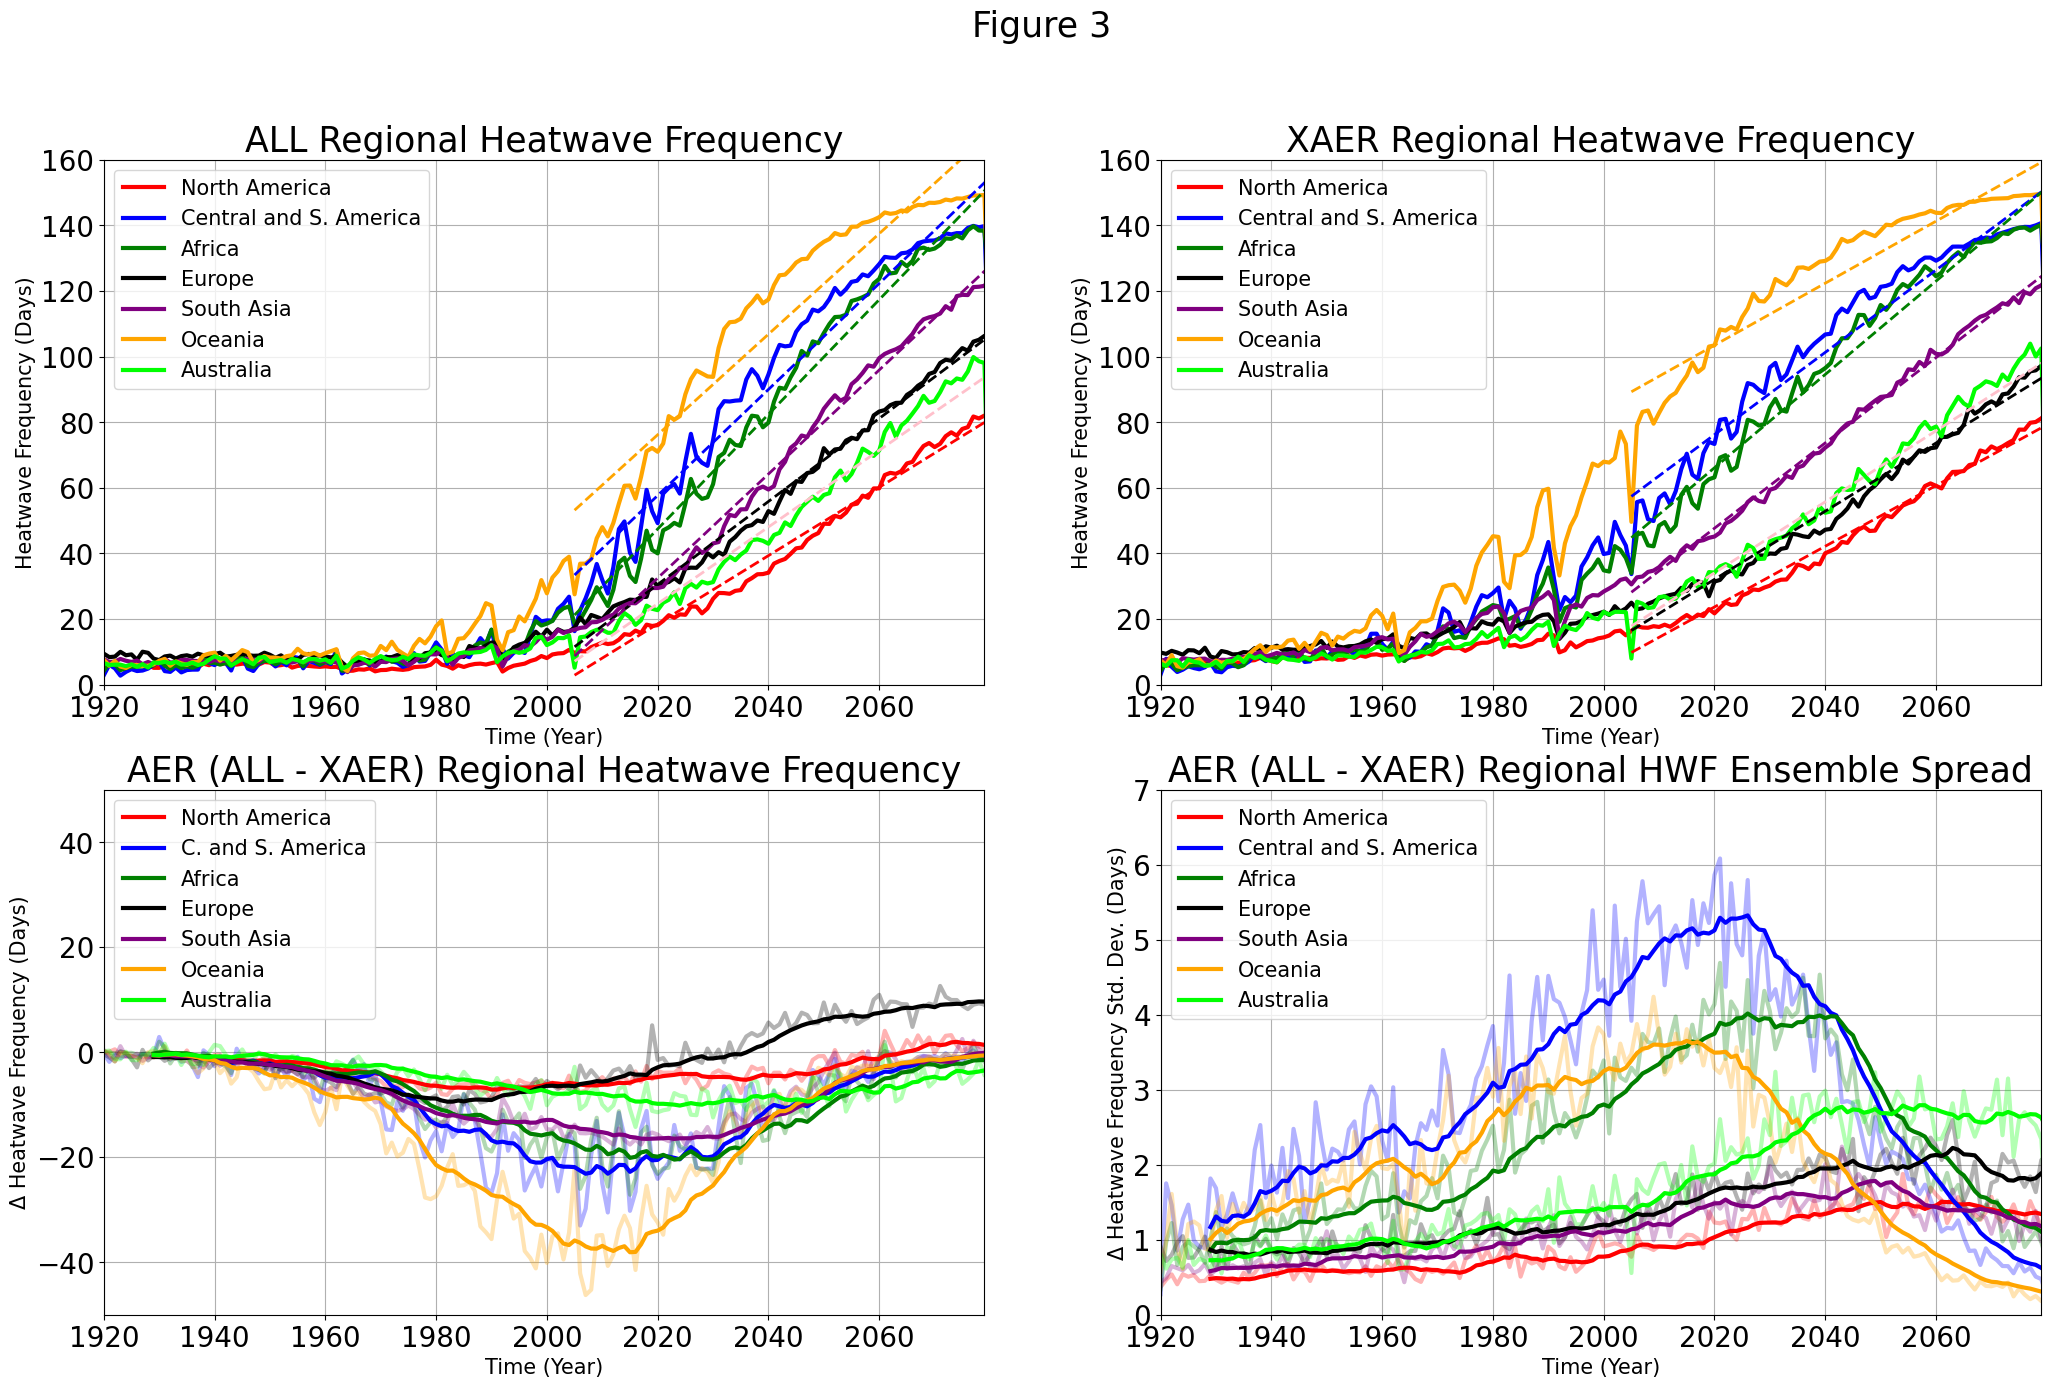

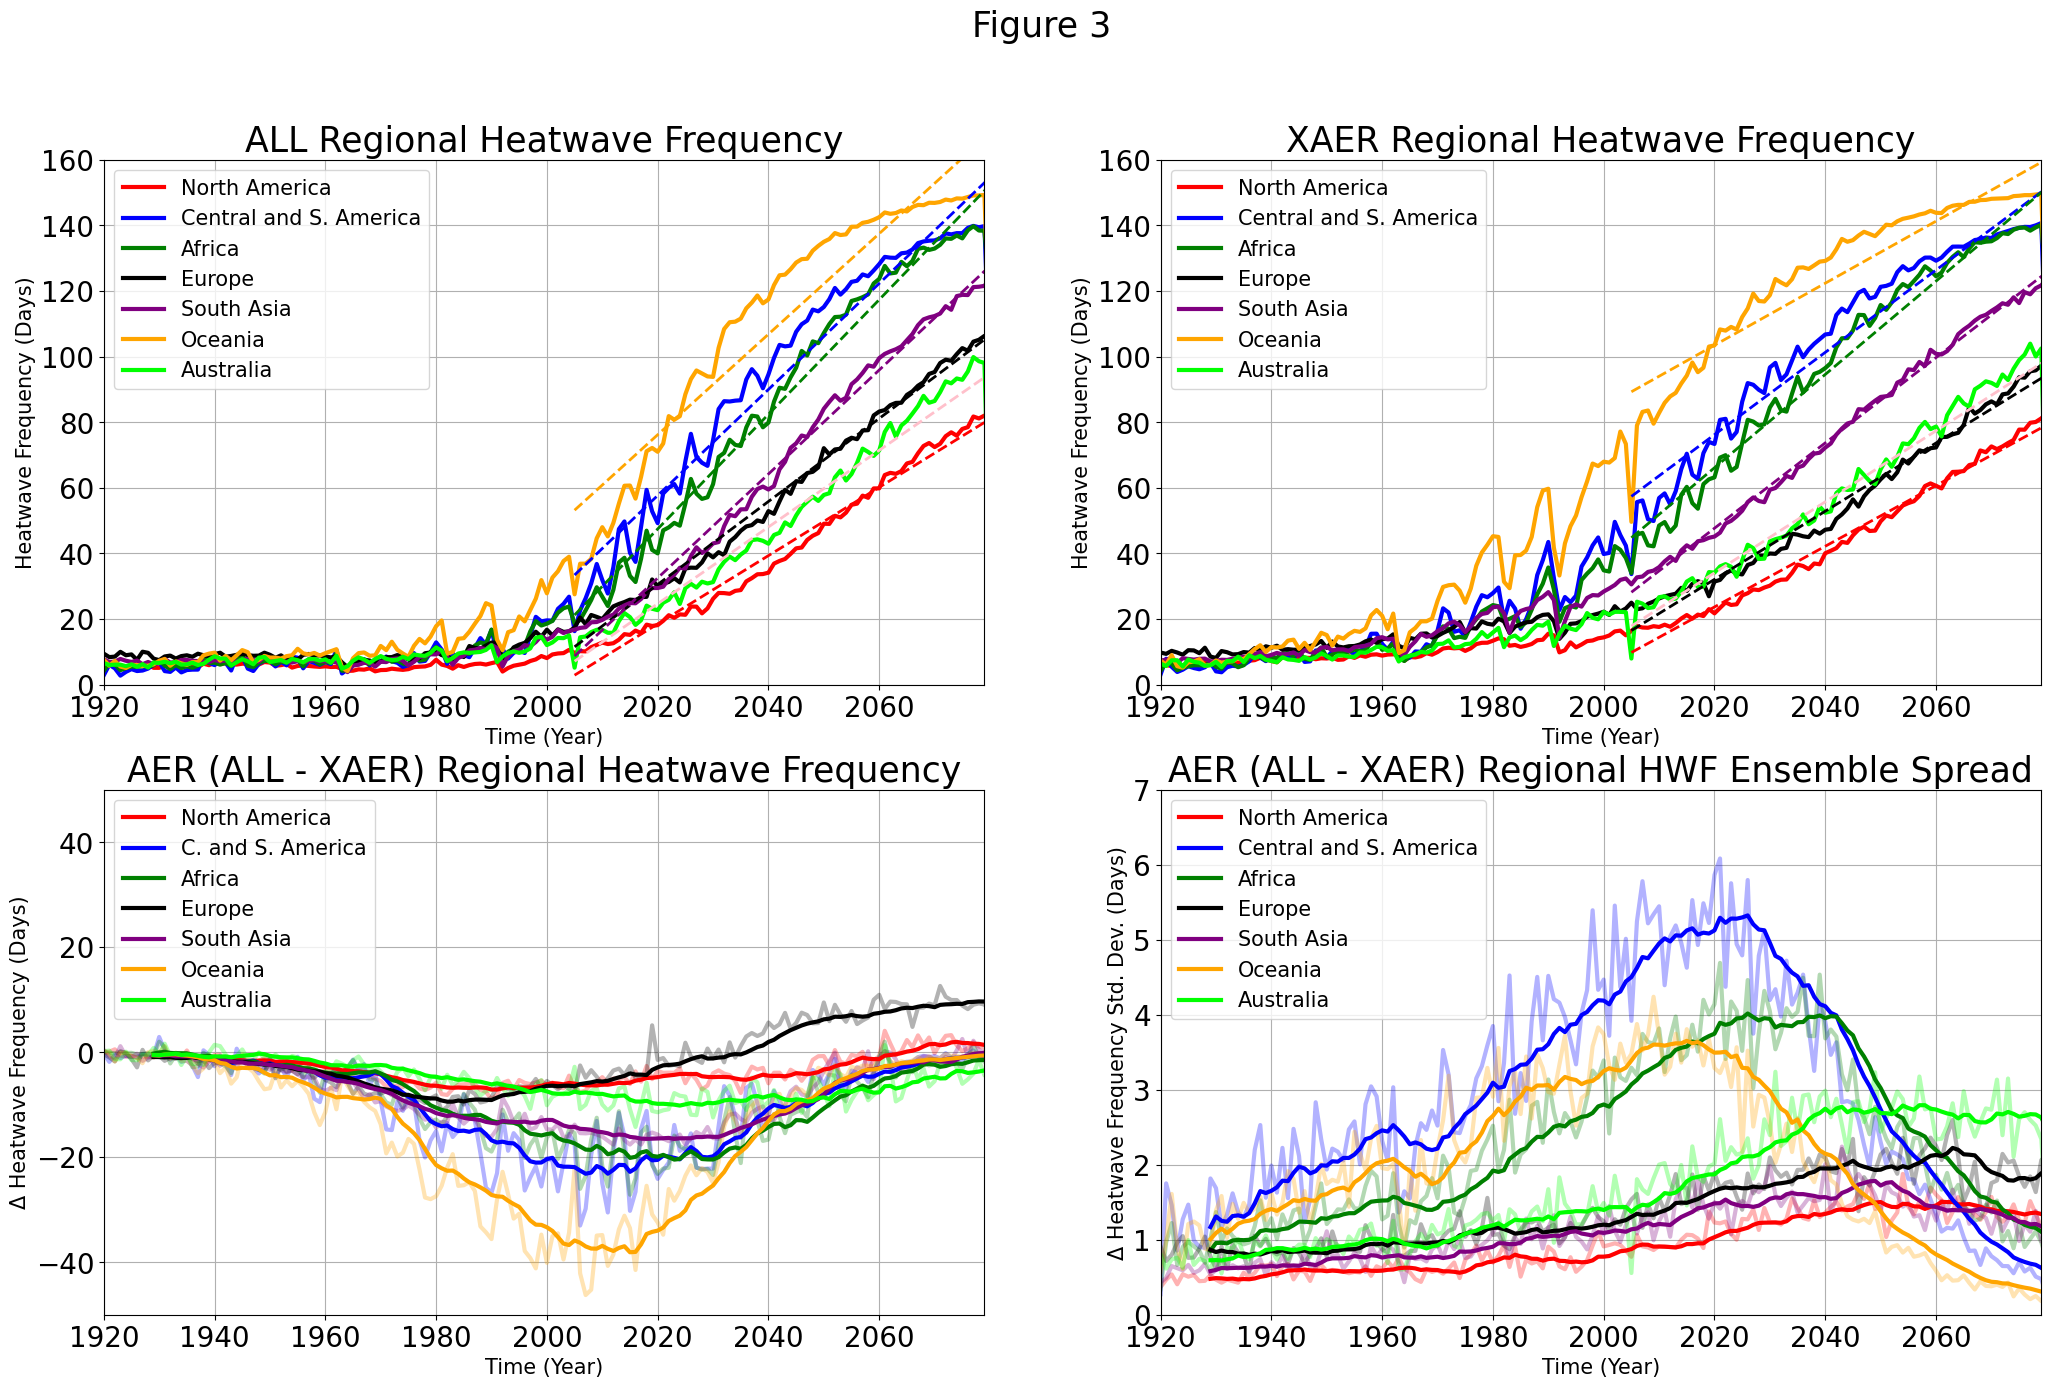

In [16]:
import regionmask

ar6_mask = regionmask.defined_regions.ar6.land.mask(all_hwf_full.lon, all_hwf_full.lat)

rc('font', **{'size': 20})
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 15), facecolor='w')
f.suptitle("Figure 3", fontsize=25)


lw = 3
all_na.plot(ax=ax1, label="North America", color="Red", linewidth=lw)
all_csa.plot(ax=ax1, label="Central and S. America", color="Blue", linewidth=lw)
all_af.plot(ax=ax1, label="Africa", color="Green", linewidth=lw)
all_euro.plot(ax=ax1, label="Europe", color="Black", linewidth=lw)
all_sa.plot(ax=ax1, label="South Asia", color="Purple", linewidth=lw)
all_oc.plot(ax=ax1, label="Oceania", color="Orange", linewidth=lw)
all_au.plot(ax=ax1, label="Australia", color="lime", linewidth=lw)

xaer_na.plot(ax=ax2, label="North America", color="Red", linewidth=lw)
xaer_csa.plot(ax=ax2, label="Central and S. America", color="Blue", linewidth=lw)
xaer_af.plot(ax=ax2, label="Africa", color="Green", linewidth=lw)
xaer_euro.plot(ax=ax2, label="Europe", color="Black", linewidth=lw)
xaer_sa.plot(ax=ax2, label="South Asia", color="Purple", linewidth=lw)
xaer_oc.plot(ax=ax2, label="Oceania", color="Orange", linewidth=lw)
xaer_au.plot(ax=ax2, label="Australia", color="lime", linewidth=lw)

lw=3
a=0.3

aer_na.plot(ax=ax3, color="Red", linewidth=lw, alpha=a)
aer_csa.plot(ax=ax3, color="Blue", linewidth=lw, alpha=a)
aer_af.plot(ax=ax3, color="Green", linewidth=lw, alpha=a)
aer_euro.plot(ax=ax3, color="Black", linewidth=lw, alpha=a)
aer_sa.plot(ax=ax3, color="Purple", linewidth=lw, alpha=a)
aer_oc.plot(ax=ax3, color="Orange", linewidth=lw, alpha=a)
aer_au.plot(ax=ax3, color="lime", linewidth=lw, alpha=a)

a = 1
t=10
aer_na.rolling(year=t).mean().plot(ax=ax3, label="North America", color="Red", linewidth=lw, alpha=a)
aer_csa.rolling(year=t).mean().plot(ax=ax3, label="C. and S. America", color="Blue", linewidth=lw, alpha=a)
aer_af.rolling(year=t).mean().plot(ax=ax3, label="Africa", color="Green", linewidth=lw, alpha=a)
aer_euro.rolling(year=t).mean().plot(ax=ax3, label="Europe", color="Black", linewidth=lw, alpha=a)
aer_sa.rolling(year=t).mean().plot(ax=ax3, label="South Asia", color="Purple", linewidth=lw, alpha=a)
aer_oc.rolling(year=t).mean().plot(ax=ax3, label="Oceania", color="Orange", linewidth=lw, alpha=a)
aer_au.rolling(year=t).mean().plot(ax=ax3, label="Australia", color="lime", linewidth=lw, alpha=a)

a=0.3

aer_std_na.plot(ax=ax4, color="Red", linewidth=lw, alpha=a)
aer_std_csa.plot(ax=ax4, color="Blue", linewidth=lw, alpha=a)
aer_std_af.plot(ax=ax4, color="Green", linewidth=lw, alpha=a)
aer_std_euro.plot(ax=ax4, color="Black", linewidth=lw, alpha=a)
aer_std_sa.plot(ax=ax4, color="Purple", linewidth=lw, alpha=a)
aer_std_oc.plot(ax=ax4, color="Orange", linewidth=lw, alpha=a)
aer_std_au.plot(ax=ax4, color="lime", linewidth=lw, alpha=a)

a=1

aer_std_na.rolling(year=t).mean().plot(ax=ax4, label="North America", color="Red", linewidth=lw, alpha=a)
aer_std_csa.rolling(year=t).mean().plot(ax=ax4, label="Central and S. America", color="Blue", linewidth=lw, alpha=a)
aer_std_af.rolling(year=t).mean().plot(ax=ax4, label="Africa", color="Green", linewidth=lw, alpha=a)
aer_std_euro.rolling(year=t).mean().plot(ax=ax4, label="Europe", color="Black", linewidth=lw, alpha=a)
aer_std_sa.rolling(year=t).mean().plot(ax=ax4, label="South Asia", color="Purple", linewidth=lw, alpha=a)
aer_std_oc.rolling(year=t).mean().plot(ax=ax4, label="Oceania", color="Orange", linewidth=lw, alpha=a)
aer_std_au.rolling(year=t).mean().plot(ax=ax4, label="Australia", color="lime", linewidth=lw, alpha=a)


fut_years = all_na.year.values[reg_index:]

ls = "--"
lw = 2

ax1.plot(fut_years, all_na_fut_m*fut_years + all_na_fut_b, color="Red", linewidth=lw, linestyle=ls)
ax1.plot(fut_years, all_csa_fut_m*fut_years + all_csa_fut_b, color="Blue", linewidth=lw, linestyle=ls)
ax1.plot(fut_years, all_af_fut_m*fut_years + all_af_fut_b, color="Green", linewidth=lw, linestyle=ls)
ax1.plot(fut_years, all_euro_fut_m*fut_years + all_euro_fut_b, color="Black", linewidth=lw, linestyle=ls)
ax1.plot(fut_years, all_sa_fut_m*fut_years + all_sa_fut_b, color="Purple", linewidth=lw, linestyle=ls)
ax1.plot(fut_years, all_oc_fut_m*fut_years + all_oc_fut_b, color="Orange", linewidth=lw, linestyle=ls)
ax1.plot(fut_years, all_au_fut_m*fut_years + all_au_fut_b, color="Pink", linewidth=lw, linestyle=ls)

ax2.plot(fut_years, xaer_na_fut_m*fut_years + xaer_na_fut_b, color="Red", linewidth=lw, linestyle=ls)
ax2.plot(fut_years, xaer_csa_fut_m*fut_years + xaer_csa_fut_b, color="Blue", linewidth=lw, linestyle=ls)
ax2.plot(fut_years, xaer_af_fut_m*fut_years + xaer_af_fut_b, color="Green", linewidth=lw, linestyle=ls)
ax2.plot(fut_years, xaer_euro_fut_m*fut_years + xaer_euro_fut_b, color="Black", linewidth=lw, linestyle=ls)
ax2.plot(fut_years, xaer_sa_fut_m*fut_years + xaer_sa_fut_b, color="Purple", linewidth=lw, linestyle=ls)
ax2.plot(fut_years, xaer_oc_fut_m*fut_years + xaer_oc_fut_b, color="Orange", linewidth=lw, linestyle=ls)
ax2.plot(fut_years, xaer_au_fut_m*fut_years + xaer_au_fut_b, color="Pink", linewidth=lw, linestyle=ls)


fz=25

ax1.set_title("ALL Regional Heatwave Frequency", fontsize=fz)
ax2.set_title("XAER Regional Heatwave Frequency", fontsize=fz)
ax3.set_title("AER (ALL - XAER) Regional Heatwave Frequency", fontsize=fz)
ax4.set_title("AER (ALL - XAER) Regional HWF Ensemble Spread", fontsize=fz)

ax1.legend(fontsize=15)
ax1.grid()
ax1.set_xlabel("Time (Year)", fontsize=15)
ax1.set_ylabel("Heatwave Frequency (Days)", fontsize=15)
ax1.set_xlim(1920, 2079)
ax1.set_ylim(0, 160)

ax2.legend(fontsize=15)
ax2.grid()
ax2.set_xlabel("Time (Year)", fontsize=15)
ax2.set_ylabel("Heatwave Frequency (Days)", fontsize=15)
ax2.set_xlim(1920, 2079)
ax2.set_ylim(0, 160)

ax3.legend(fontsize=15)
ax3.grid()
ax3.set_xlabel("Time (Year)", fontsize=15)
ax3.set_ylabel("Δ Heatwave Frequency (Days)", fontsize=15)
ax3.set_xlim(1920, 2079)
ax3.set_ylim(-50, 50)

ax4.legend(fontsize=15)
ax4.grid()
ax4.set_xlabel("Time (Year)", fontsize=15)
ax4.set_ylabel("Δ Heatwave Frequency Std. Dev. (Days)", fontsize=15)
ax4.set_xlim(1920, 2079)
ax4.set_ylim(0, 7)

f

In [7]:
HEAD_DIR = "/projects/dgs/persad_research/heat_research/data/"
landfrac = xarray.open_dataset(HEAD_DIR + "LANDFRAC/DOWNLOAD/b.e11.B1850C5CN.f09_g16.005.cam.h0.LANDFRAC.040001-049912.nc")["LANDFRAC"].mean(dim="time")

SSP_pop_data = xarray.open_dataset(HEAD_DIR + "/SSP3_POP/ssp3_2010.nc")["ssp3_2010"]
SSP_pop_data = SSP_pop_data.assign_coords({"lon": (SSP_pop_data.coords['lon'] % 360)}).sortby("lon")

lons = np.linspace(landfrac.lon.values[0], landfrac.lon.values[-1], landfrac.lon.values.size + 1)
lats = np.linspace(landfrac.lat.values[0], landfrac.lat.values[-1], landfrac.lat.values.size + 1)

SSP_pop_data = SSP_pop_data.sortby(SSP_pop_data.lon)
SSP_pop_data = SSP_pop_data.groupby_bins("lon", lons).sum().groupby_bins("lat", lats).sum().fillna(0).rename({'lat_bins': 'lat','lon_bins': 'lon'})

SSP_pop_data["lat"] = landfrac.lat
SSP_pop_data["lon"] = landfrac.lon

all_hwf_w_spatial = all_hwf_full.weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").load()
all_hwf_w_spatial_mavg = all_hwf_w_spatial.mean(dim="member")

xaer_hwf_w_spatial = xaer_hwf_full.weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon")
xaer_hwf_w_spatial_mavg = xaer_hwf_w_spatial.mean(dim="member")

In [9]:
ar6_mask = regionmask.defined_regions.ar6.land.mask(all_hwf_full.lon, all_hwf_full.lat)

all_w_na = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 6).weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").mean(dim="member")
all_w_csa = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 15).where(ar6_mask >= 7).weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").mean(dim="member")
all_w_af = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 27).where(ar6_mask >= 20).weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").mean(dim="member")
all_w_euro = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 19).where(ar6_mask >= 16).weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").mean(dim="member")
all_w_sa = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 37).where(ar6_mask >= 32).weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").mean(dim="member")
all_w_oc = all_hwf_full.where(landfrac > 0).where(ar6_mask == 38).weighted(lat_weight).mean(dim="lat").mean(dim="lon").mean(dim="member")
all_w_au = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 42).where(ar6_mask >= 39).weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").mean(dim="member")

xaer_w_na = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 6).weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").mean(dim="member")
xaer_w_csa = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 15).where(ar6_mask >= 7).weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").mean(dim="member")
xaer_w_af = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 27).where(ar6_mask >= 20).weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").mean(dim="member")
xaer_w_euro = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 19).where(ar6_mask >= 16).weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").mean(dim="member")
xaer_w_sa = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 37).where(ar6_mask >= 32).weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").mean(dim="member")
xaer_w_oc = xaer_hwf_full.where(landfrac > 0).where(ar6_mask == 38).weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").mean(dim="member")
xaer_w_au = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 42).where(ar6_mask >= 39).weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").mean(dim="member")

aer_w_na = all_w_na - xaer_w_na
aer_w_csa = all_w_csa - xaer_w_csa
aer_w_af = all_w_af - xaer_w_af
aer_w_euro = all_w_euro - xaer_w_euro
aer_w_sa = all_w_sa - xaer_w_sa
aer_w_oc = all_w_oc - xaer_w_oc
aer_w_au = all_w_au - xaer_w_au

In [22]:
total = xarray.open_dataset(HEAD_DIR + "/SSP3_POP/ssp3_2010.nc")["ssp3_2010"].sum()
100*((SSP_pop_data.sum() - total) / total)

<xarray.DataArray 'ssp3_2010' ()>
array(-0.70304857)

In [ ]:
# HEAD_DIR = "/projects/dgs/persad_research/heat_research/data/"

# SSP_pop_data = xarray.open_dataset(HEAD_DIR + "/SSP3_POP/ssp3_2010.nc")["ssp3_2010"]
# #SSP_pop_data.coords['lon'] = (SSP_pop_data.coords['lon'] % 360)
# SSP_pop_data = SSP_pop_data.assign_coords({"lon": (SSP_pop_data.coords['lon'] % 360)}).sortby("lon")

# lons = np.linspace(landfrac.lon.values[0], landfrac.lon.values[-1], landfrac.lon.values.size)
# lats = np.linspace(landfrac.lat.values[0], landfrac.lat.values[-1], landfrac.lat.values.size)

# SSP_pop_data = SSP_pop_data.sortby(SSP_pop_data.lon)
# SSP_pop_data = SSP_pop_data.groupby_bins("lon", lons).sum().groupby_bins("lat", lats).sum().fillna(0).rename({'lat_bins': 'lat','lon_bins': 'lon'})
# SSP_pop_data = SSP_pop_data# / SSP_pop_data.sum()

# landfrac = xarray.open_dataset(HEAD_DIR + "LANDFRAC/DOWNLOAD/b.e11.B1850C5CN.f09_g16.005.cam.h0.LANDFRAC.040001-049912.nc")["LANDFRAC"].mean(dim="time")
# # SSP_pop_data["lat"] = landfrac.lat
# # SSP_pop_data["lon"] = landfrac.lon

# proj = ccrs.Robinson()
# f, ax1 = plt.subplots(1, 1, figsize=(10, 7), facecolor='w', subplot_kw=dict(projection=proj))

# (SSP_pop_data> 0).plot(ax=ax1, transform=ccrs.PlateCarree(), linewidths=1, cmap="Blues")

# ax1.coastlines()
# ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)

In [ ]:
ds = 100*((xaer_hwf_w_spatial_mavg - xaer_hwf_spatial_mavg) / xaer_hwf_spatial_mavg).values

print(f"Hist: {np.min(ds[10:85])} {np.max(ds[10:85])}")
print(f"Fut: {np.min(ds[85:])} {np.max(ds[85:])}")
print(f"For XAER, AVGS: {np.mean(ds[10:85])} {np.mean(ds[85:])}")

In [ ]:
ds = 100*((all_hwf_w_spatial_mavg - all_hwf_spatial_mavg) / all_hwf_spatial_mavg).values

print(f"Hist: {np.min(ds[10:85])} {np.max(ds[10:85])}")
print(f"Fut: {np.min(ds[85:])} {np.max(ds[85:])}")
print(f"For ALL, AVGS: {np.mean(ds[10:85])} {np.mean(ds[85:])}")

In [ ]:
ds

In [ ]:
aer_hwf_w_spatial_mavg = (all_hwf_w_spatial_mavg - xaer_hwf_w_spatial_mavg)
aer_hwf_spatial_mavg = (all_hwf_spatial_mavg - xaer_hwf_spatial_mavg)

In [ ]:
all_hwf_w_spatial_mavg.year.values[90]

In [ ]:
ds = ((aer_hwf_w_spatial_mavg - aer_hwf_spatial_mavg) / aer_hwf_spatial_mavg).values

print(f"Hist: {np.mean(ds[10:85])} {np.min(ds[10:85])}")
print(f"Fut: {np.mean(ds[85:])} {np.min(ds[85:])}")
print(f"wp: {np.max(ds[70:90])} {np.min(ds[70:90])}")


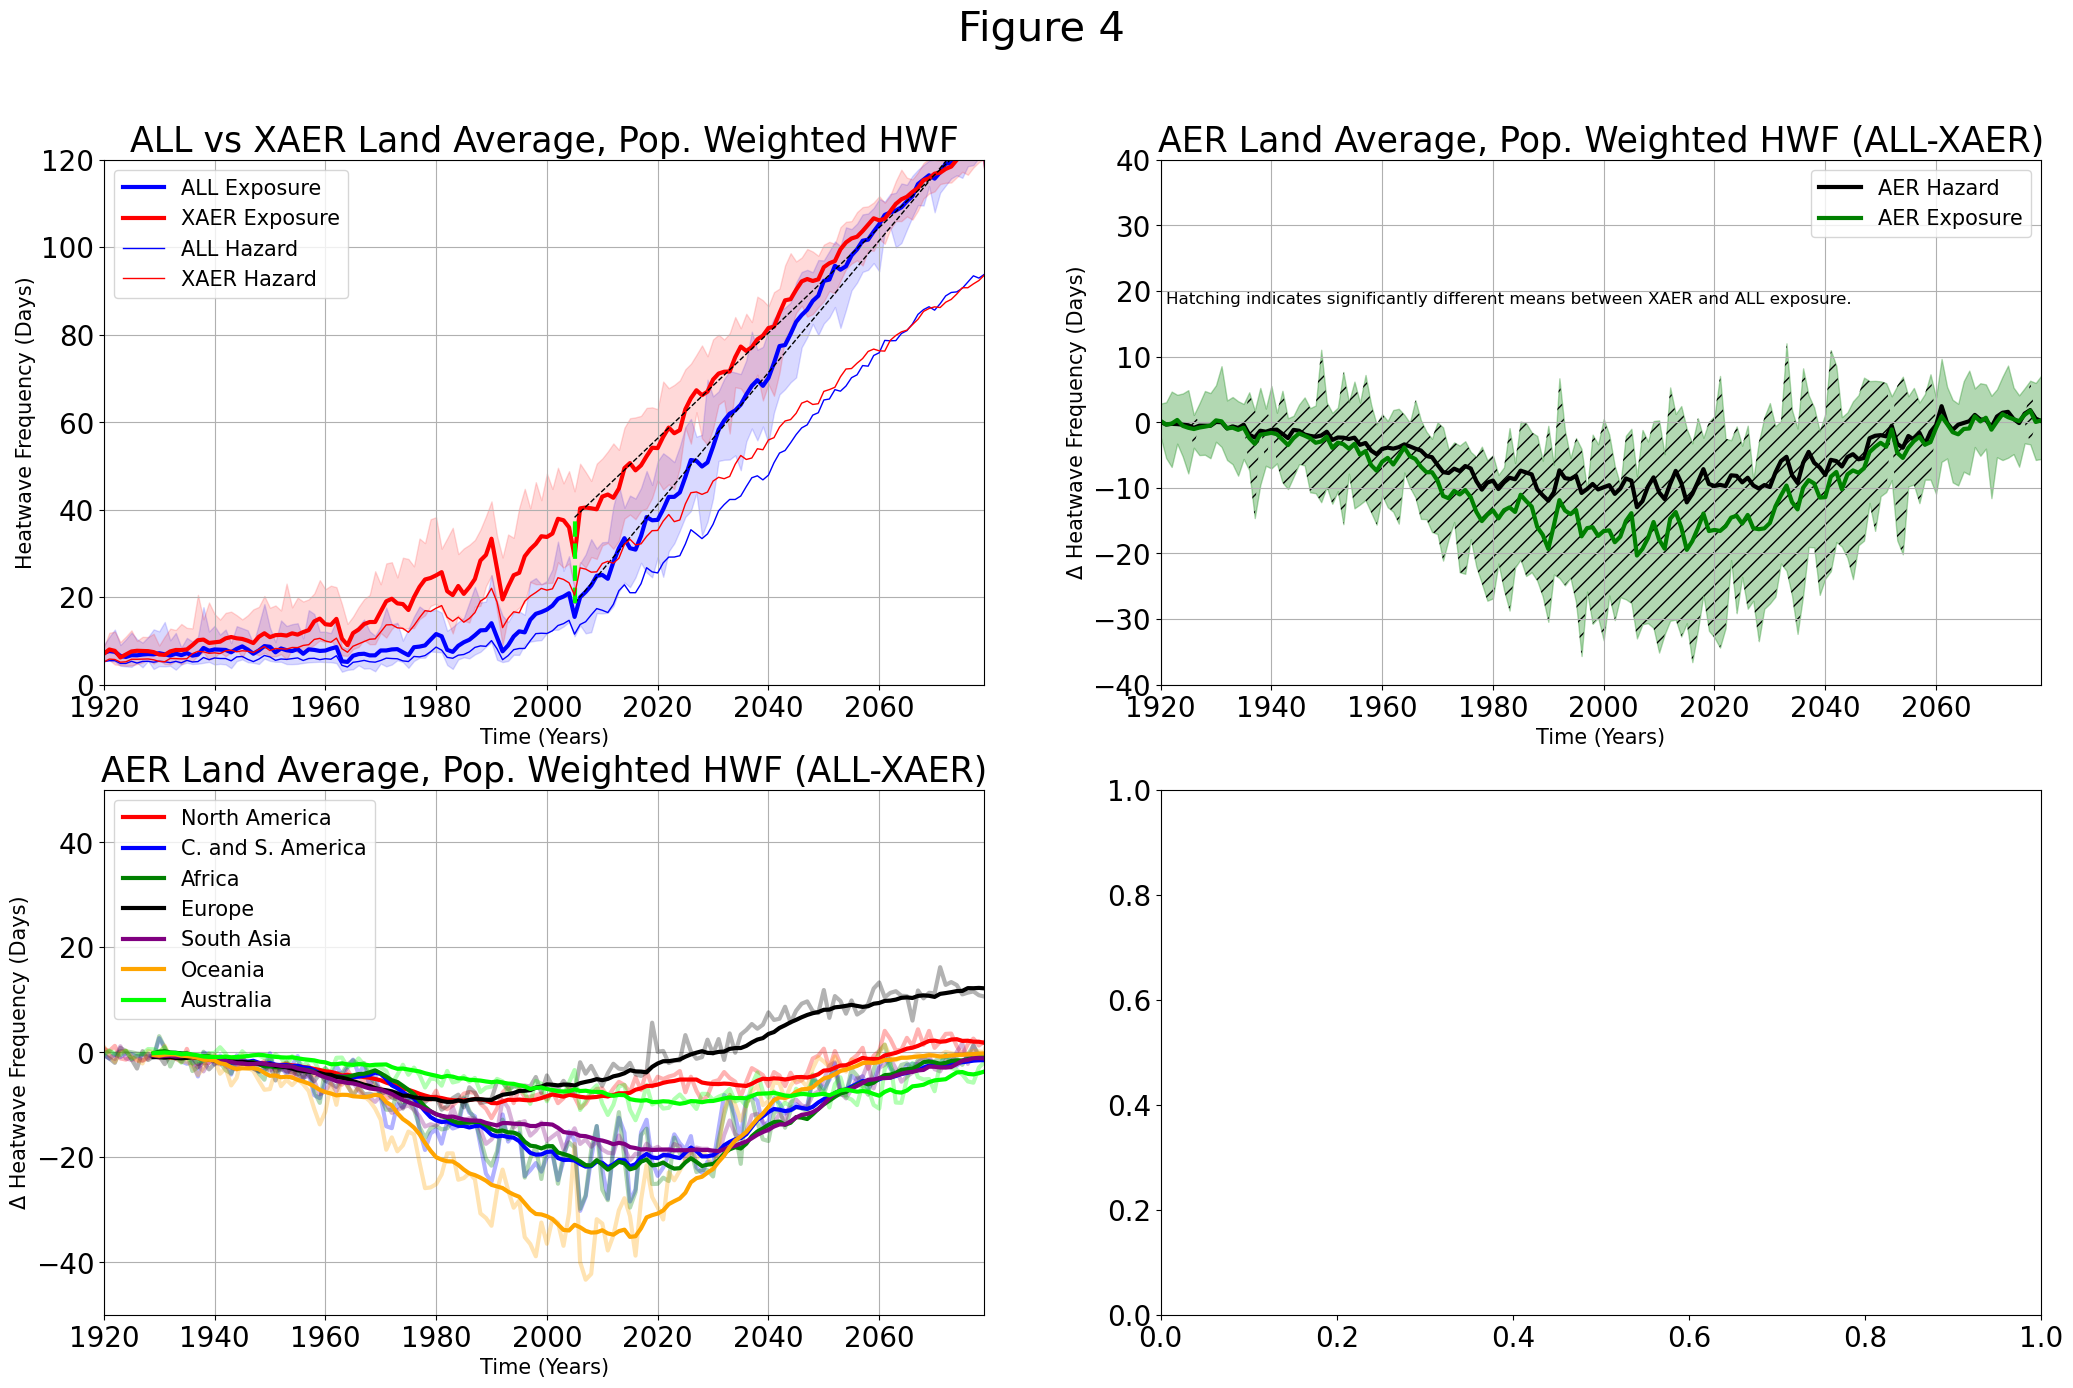

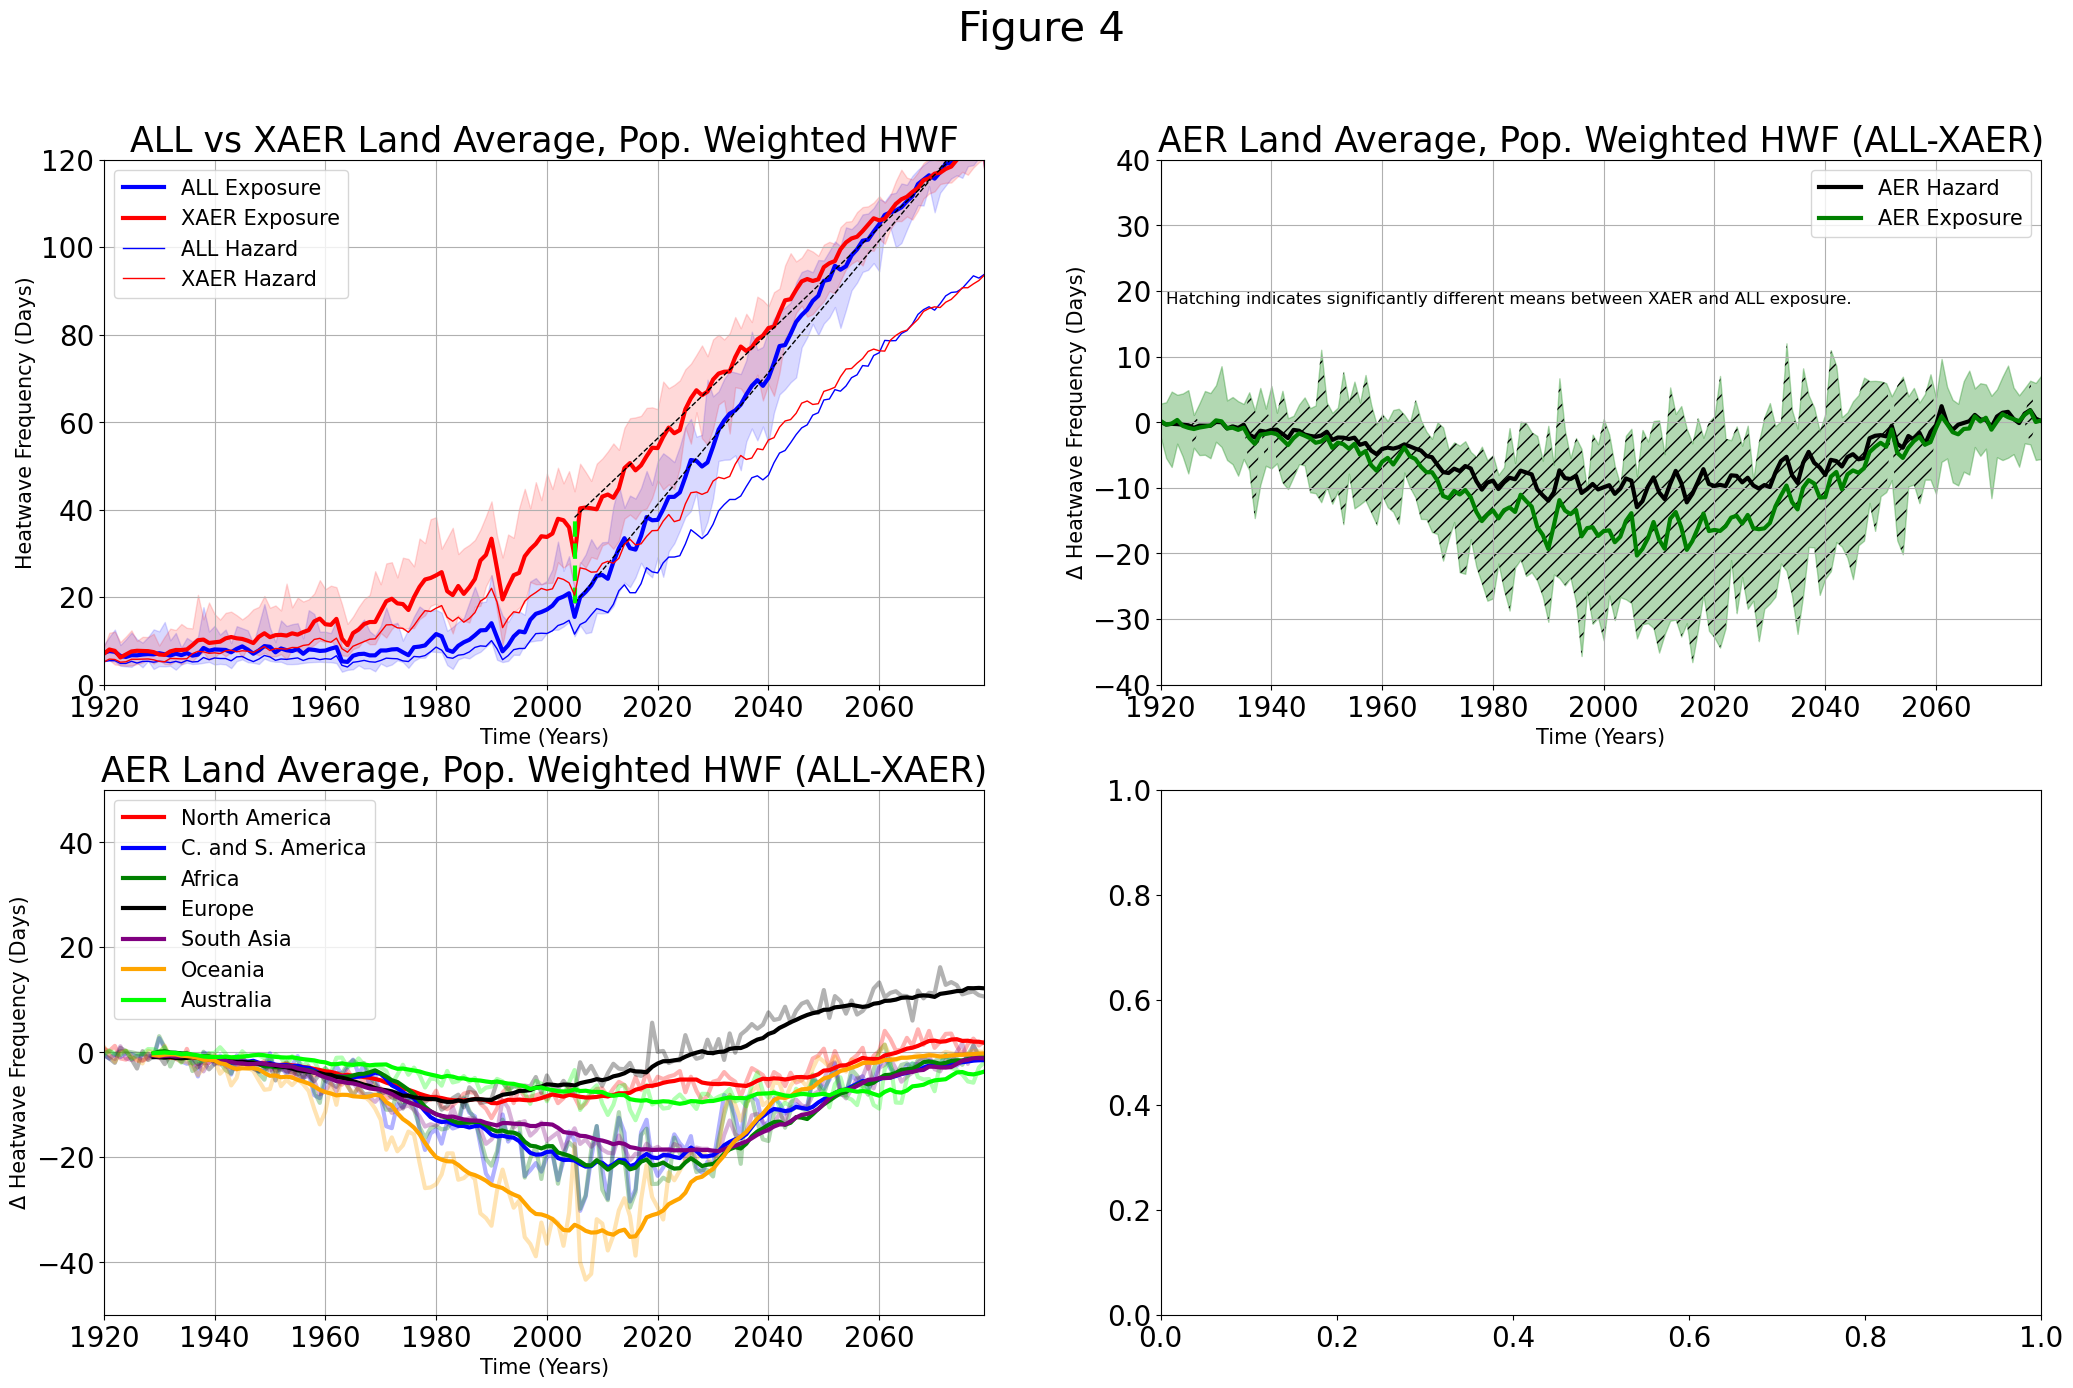

In [10]:
rc('font', **{'size': 20})
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(25, 15), facecolor='w')
f.suptitle("Figure 4", fontsize=30)

reg_index = 85

all_hwf_w_spatial_mavg.plot(ax=ax1, color="blue", linewidth=3, label="ALL Exposure")
ax1.fill_between(all_hwf_w_spatial.year.values, all_hwf_w_spatial.min(dim="member"), all_hwf_w_spatial.max(dim="member"), color="blue", alpha=0.15)
slope, inter, rval, pval, stderr = linregress(all_hwf_w_spatial_mavg.year.values[reg_index:], all_hwf_w_spatial_mavg.values[reg_index:])
ax1.plot(all_hwf_w_spatial_mavg.year.values[reg_index:], slope*all_hwf_w_spatial_mavg.year.values[reg_index:] + inter, linestyle="--", color="Black", linewidth=1, alpha=1)
#ax1.text(2030, 22, '{0:.{1}f} Days/Year'.format(slope, 2), color="blue")

xaer_hwf_w_spatial_mavg.plot(ax=ax1, color="red", linewidth=3, label="XAER Exposure")
ax1.fill_between(xaer_hwf_w_spatial.year.values, xaer_hwf_w_spatial.min(dim="member"), xaer_hwf_w_spatial.max(dim="member"), color="red", alpha=0.15)
xslope, xinter, rval, pval, stderr = linregress(xaer_hwf_w_spatial_mavg.year.values[reg_index:], xaer_hwf_w_spatial_mavg.values[reg_index:])
ax1.plot(xaer_hwf_w_spatial_mavg.year.values[reg_index:], xslope*xaer_hwf_w_spatial_mavg.year.values[reg_index:] + xinter, linestyle="--", color="Black", linewidth=1, alpha=1)
#ax1.text(1980, 62, '{0:.{1}f} Days/Year'.format(xslope, 2), color="red")

ax1.plot([xaer_hwf_w_spatial_mavg.year.values[reg_index], xaer_hwf_w_spatial_mavg.year.values[reg_index]], [inter + 2005*slope, xinter + 2005*xslope], color="lime", linestyle="--", linewidth=3)
#ax1.text(1965, 34, '{0:.{1}f} Days'.format(abs(inter + 2005*slope - (xinter + 2005*xslope)), 2), color="limegreen")

all_hwf_spatial_mavg.plot(ax=ax1, color="Blue", linewidth=1, linestyle="-", alpha=1, label="ALL Hazard")
xaer_hwf_spatial_mavg.plot(ax=ax1, color="Red", linewidth=1, linestyle="-", alpha=1, label="XAER Hazard")

(all_hwf_spatial_mavg - xaer_hwf_spatial_mavg).plot(ax=ax2, color="Black", linestyle="-", linewidth=3, label="AER Hazard")

t_value, p_value = ttest_ind(xaer_hwf_w_spatial, all_hwf_w_spatial, equal_var=False)
(all_hwf_w_spatial_mavg - xaer_hwf_w_spatial_mavg).plot(ax=ax2, color="Green", linewidth=3, label="AER Exposure")
ax2.fill_between(xaer_hwf_w_spatial.year.values, (all_hwf_w_spatial - xaer_hwf_w_spatial).min(dim="member"), (all_hwf_w_spatial - xaer_hwf_w_spatial).max(dim="member"), color="Green", alpha=0.3)
ax2.fill_between(xaer_hwf_w_spatial.year.values, (all_hwf_w_spatial - xaer_hwf_w_spatial).min(dim="member")*(p_value < 0.05), (all_hwf_w_spatial - xaer_hwf_w_spatial).max(dim="member")*(p_value < 0.05), hatch="//", alpha=0)
ax2.text(1921, 18, "Hatching indicates significantly different means between XAER and ALL exposure.", fontsize=12)

ax1.set_ylabel("Heatwave Frequency (Days)", fontsize=15)
ax1.set_xlabel("Time (Years)", fontsize=15)

ax1.set_title("ALL vs XAER Land Average, Pop. Weighted HWF", fontsize=25)
ax1.legend(fontsize=15)
ax1.grid()
ax1.set_xlim(all_hwf_w_spatial_mavg.year.values[0], all_hwf_w_spatial_mavg.year.values[-1])
ax1.set_ylim(0, 120)
ax1.set_xlim(1920, 2079)

ax2.set_ylabel("Δ Heatwave Frequency (Days)", fontsize=15)
ax2.set_xlabel("Time (Years)", fontsize=15)

ax2.set_title("AER Land Average, Pop. Weighted HWF (ALL-XAER)", fontsize=25)
ax2.legend(fontsize=15)
ax2.grid()
ax2.set_xlim(all_hwf_w_spatial_mavg.year.values[0], all_hwf_w_spatial_mavg.year.values[-1])
ax2.set_ylim(-40, 40)
ax2.set_xlim(1920, 2079)

lw=3
a=0.3

aer_w_na.plot(ax=ax3, color="Red", linewidth=lw, alpha=a)
aer_w_csa.plot(ax=ax3, color="Blue", linewidth=lw, alpha=a)
aer_w_af.plot(ax=ax3, color="Green", linewidth=lw, alpha=a)
aer_w_euro.plot(ax=ax3, color="Black", linewidth=lw, alpha=a)
aer_w_sa.plot(ax=ax3, color="Purple", linewidth=lw, alpha=a)
aer_w_oc.plot(ax=ax3, color="Orange", linewidth=lw, alpha=a)
aer_w_au.plot(ax=ax3, color="lime", linewidth=lw, alpha=a)

a = 1
t=10
aer_w_na.rolling(year=t).mean().plot(ax=ax3, label="North America", color="Red", linewidth=lw, alpha=a)
aer_w_csa.rolling(year=t).mean().plot(ax=ax3, label="C. and S. America", color="Blue", linewidth=lw, alpha=a)
aer_w_af.rolling(year=t).mean().plot(ax=ax3, label="Africa", color="Green", linewidth=lw, alpha=a)
aer_w_euro.rolling(year=t).mean().plot(ax=ax3, label="Europe", color="Black", linewidth=lw, alpha=a)
aer_w_sa.rolling(year=t).mean().plot(ax=ax3, label="South Asia", color="Purple", linewidth=lw, alpha=a)
aer_w_oc.rolling(year=t).mean().plot(ax=ax3, label="Oceania", color="Orange", linewidth=lw, alpha=a)
aer_w_au.rolling(year=t).mean().plot(ax=ax3, label="Australia", color="lime", linewidth=lw, alpha=a)

ax3.set_title("AER Land Average, Pop. Weighted HWF (ALL-XAER)", fontsize=25)
ax3.legend(fontsize=15)
ax3.grid()
ax3.set_xlim(all_hwf_w_spatial_mavg.year.values[0], all_hwf_w_spatial_mavg.year.values[-1])
ax3.set_ylim(-50, 50)
ax3.set_xlim(1920, 2079)

ax3.set_ylabel("Δ Heatwave Frequency (Days)", fontsize=15)
ax3.set_xlabel("Time (Years)", fontsize=15)

f

In [ ]:
ar6_mask = regionmask.defined_regions.ar6.land.mask(all_hwf_full.lon, all_hwf_full.lat)

all_w_na = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 6).weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").rename("Heatwave Frequency (Days)")
all_w_csa = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 15).where(ar6_mask >= 7).weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").rename("Heatwave Frequency (Days)")
all_w_af = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 27).where(ar6_mask >= 20).weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").rename("Heatwave Frequency (Days)")
all_w_euro = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 19).where(ar6_mask >= 16).weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").rename("Heatwave Frequency (Days)")
all_w_sa = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 37).where(ar6_mask >= 32).weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").rename("Heatwave Frequency (Days)")
all_w_oc = all_hwf_full.where(landfrac > 0).where(ar6_mask == 38).weighted(lat_weight).mean(dim="lat").mean(dim="lon").rename("Heatwave Frequency (Days)")
all_w_au = all_hwf_full.where(landfrac > 0).where(ar6_mask <= 42).where(ar6_mask >= 39).weighted(lat_weight).mean(dim="lat").mean(dim="lon").rename("Heatwave Frequency (Days)")

xaer_w_na = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 6).weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").rename("Heatwave Frequency (Days)")
xaer_w_csa = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 15).where(ar6_mask >= 7).weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").rename("Heatwave Frequency (Days)")
xaer_w_af = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 27).where(ar6_mask >= 20).weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").rename("Heatwave Frequency (Days)")
xaer_w_euro = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 19).where(ar6_mask >= 16).weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").rename("Heatwave Frequency (Days)")
xaer_w_sa = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 37).where(ar6_mask >= 32).weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").rename("Heatwave Frequency (Days)")
xaer_w_oc = xaer_hwf_full.where(landfrac > 0).where(ar6_mask == 38).weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").rename("Heatwave Frequency (Days)")
xaer_w_au = xaer_hwf_full.where(landfrac > 0).where(ar6_mask <= 42).where(ar6_mask >= 39).weighted(SSP_pop_data).mean(dim="lat").mean(dim="lon").rename("Heatwave Frequency (Days)")

In [ ]:
rc('font', **{'size': 20})
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(55, 35), facecolor='w')
f.suptitle("Figure 5", fontsize=60)

lw = 3

ax1.fill_between(xaer_w_na.year.values, xaer_w_na.min(dim="member"), xaer_w_na.max(dim="member"), color="Red", alpha=0.3)
xaer_w_na.mean(dim="member").plot(ax=ax1, color="Red", linewidth=lw, label="XAER")
ax1.fill_between(all_w_na.year.values, all_w_na.min(dim="member"), all_w_na.max(dim="member"), color="Blue", alpha=0.3)
all_w_na.mean(dim="member").plot(ax=ax1, color="Blue", linewidth=lw, label="ALL")

ax2.fill_between(xaer_w_csa.year.values, xaer_w_csa.min(dim="member"), xaer_w_csa.max(dim="member"), color="Red", alpha=0.3)
xaer_w_csa.mean(dim="member").plot(ax=ax2, color="Red", linewidth=lw, label="XAER")
ax2.fill_between(all_w_csa.year.values, all_w_csa.min(dim="member"), all_w_csa.max(dim="member"), color="Blue", alpha=0.3)
all_w_csa.mean(dim="member").plot(ax=ax2, color="Blue", linewidth=lw, label="ALL")

ax3.fill_between(xaer_w_af.year.values, xaer_w_af.min(dim="member"), xaer_w_af.max(dim="member"), color="Red", alpha=0.3)
xaer_w_af.mean(dim="member").plot(ax=ax3, color="Red", linewidth=lw, label="XAER")
ax3.fill_between(all_w_af.year.values, all_w_af.min(dim="member"), all_w_af.max(dim="member"), color="Blue", alpha=0.3)
all_w_af.mean(dim="member").plot(ax=ax3, color="Blue", linewidth=lw, label="ALL")

ax4.fill_between(xaer_w_euro.year.values, xaer_w_euro.min(dim="member"), xaer_w_euro.max(dim="member"), color="Red", alpha=0.3)
xaer_w_euro.mean(dim="member").plot(ax=ax4, color="Red", linewidth=lw, label="XAER")
ax4.fill_between(all_w_euro.year.values, all_w_euro.min(dim="member"), all_w_euro.max(dim="member"), color="Blue", alpha=0.3)
all_w_euro.mean(dim="member").plot(ax=ax4, color="Blue", linewidth=lw, label="ALL")

ax5.fill_between(xaer_w_sa.year.values, xaer_w_sa.min(dim="member"), xaer_w_sa.max(dim="member"), color="Red", alpha=0.3)
xaer_w_sa.mean(dim="member").plot(ax=ax5, color="Red", linewidth=lw, label="XAER")
ax5.fill_between(all_w_sa.year.values, all_w_sa.min(dim="member"), all_w_sa.max(dim="member"), color="Blue", alpha=0.3)
all_w_sa.mean(dim="member").plot(ax=ax5, color="Blue", linewidth=lw, label="ALL")

ax6.fill_between(xaer_w_oc.year.values, xaer_w_oc.min(dim="member"), xaer_w_oc.max(dim="member"), color="Red", alpha=0.3)
xaer_w_oc.mean(dim="member").plot(ax=ax6, color="Red", linewidth=lw, label="XAER")
ax6.fill_between(all_w_oc.year.values, all_w_oc.min(dim="member"), all_w_oc.max(dim="member"), color="Blue", alpha=0.3)
all_w_oc.mean(dim="member").plot(ax=ax6, color="Blue", linewidth=lw, label="ALL")

ax7.fill_between(xaer_w_au.year.values, xaer_w_au.min(dim="member"), xaer_w_au.max(dim="member"), color="Red", alpha=0.3)
xaer_w_au.mean(dim="member").plot(ax=ax7, color="Red", linewidth=lw, label="XAER")
ax7.fill_between(all_w_au.year.values, all_w_au.min(dim="member"), all_w_au.max(dim="member"), color="Blue", alpha=0.3)
all_w_au.mean(dim="member").plot(ax=ax7, color="Blue", linewidth=lw, label="ALL")

fz = 45

ax1.set_title("Pop. Weighted ALL vs XAER HWF, N. America", fontsize=fz)
ax2.set_title("Pop. Weighted ALL vs XAER HWF, C.S. America", fontsize=fz)
ax3.set_title("Pop. Weighted ALL vs XAER HWF, Africa", fontsize=fz)
ax4.set_title("Pop. Weighted ALL vs XAER HWF, Europe", fontsize=fz)
ax5.set_title("Pop. Weighted ALL vs XAER HWF, South Asia", fontsize=fz)
ax6.set_title("Pop. Weighted ALL vs XAER HWF, Oceania", fontsize=fz)
ax7.set_title("Pop. Weighted ALL vs XAER HWF, Australia", fontsize=fz)

yu = 160

ax1.grid()
ax1.set_xlim(1920,2079)
ax1.set_ylim(0, yu)
ax1.set_xlabel('Time (Year)')
ax1.legend()
ax2.grid()
ax2.set_xlim(1920,2079)
ax2.set_ylim(0, yu)
ax2.set_xlabel('Time (Year)')
ax2.legend()
ax3.grid()
ax3.set_xlim(1920,2079)
ax3.set_ylim(0, yu)
ax3.set_xlabel('Time (Year)')
ax3.legend()
ax4.grid()
ax4.set_xlim(1920,2079)
ax4.set_ylim(0, yu)
ax4.set_xlabel('Time (Year)')
ax4.legend()
ax5.grid()
ax5.set_xlim(1920,2079)
ax5.set_ylim(0, yu)
ax5.set_xlabel('Time (Year)')
ax5.legend()
ax6.grid()
ax6.set_xlim(1920,2079)
ax6.set_ylim(0, yu)
ax6.set_xlabel('Time (Year)')
ax6.legend()
ax7.grid()
ax7.set_xlim(1920,2079)
ax7.set_ylim(0, yu)
ax7.set_xlabel('Time (Year)')
ax7.legend()

f

In [ ]:
for i in range(1, 8):
    print(f"ax{i}.grid()")
    print(f"ax{i}.set_xlim(1920,2079)")
    print(f"ax{i}.set_ylim(0, yu)")
    print(f"ax{i}.set_xlabel('Time (Year)')")
    print(f"ax{i}.legend()")

In [ ]:
from os import listdir

DIR_PATH = "/projects/dgs/persad_research/heat_research/data/MERRA2/daily_temp/"
paths = [DIR_PATH + name for name in listdir(DIR_PATH) if ".nc4" in name]
paths.sort()

MERRA2_tmin = xarray.open_mfdataset(paths, combine="by_coords")["T2MMIN"].load()
MERRA2_tmin = MERRA2_tmin.convert_calendar("noleap")

path = "/projects/dgs/persad_research/heat_research/data/TREFHTMN/ALL/DOWNLOAD/b.e11.B20TRC5CNBDRD.f09_g16.002.cam.h1.TREFHTMN.19200101-20051231.nc"
CESM1_tmin = xarray.open_dataset(path)["TREFHTMN"]
CESM1_tmin = CESM1_tmin.sel(time=slice(MERRA2_tmin.time.values[0], CESM1_tmin.time.values[-1]))
MERRA2_tmin = MERRA2_tmin.sel(time=slice(MERRA2_tmin.time.values[0], CESM1_tmin.time.values[-1]))

MERRA2_upscaled = MERRA2_tmin

MERRA2_upscaled.coords['lon'] = MERRA2_upscaled.coords['lon'] + 180
MERRA2_upscaled = MERRA2_upscaled.sortby(MERRA2_upscaled.lon)
MERRA2_upscaled = MERRA2_upscaled.interp(lat=CESM1_tmin.lat).interp(lon=CESM1_tmin.lon)
MERRA2_upscaled.values = np.concatenate([MERRA2_upscaled.sel(lon=slice(180, 360)).values, MERRA2_upscaled.sel(lon=slice(0, 179)).values], axis=2)

In [ ]:
MERRA2_autocorr_vals = np.zeros((MERRA2_upscaled.shape[1], MERRA2_upscaled.shape[2]))

for i in range(0, MERRA2_upscaled.shape[1]):
    for j in range(0, MERRA2_upscaled.shape[2]):
        m, b = np.polyfit(np.arange(MERRA2_upscaled.values.shape[0]), MERRA2_upscaled.values[:, i, j], 1)
        detrended = MERRA2_upscaled.values[:, i, j] - (m*np.arange(MERRA2_upscaled.values.shape[0]) + b)
        MERRA2_autocorr_vals[i, j] = pearsonr(detrended[1:], detrended[:-1])[0]
        
CESM1_autocorr_vals = np.zeros((CESM1_tmin.shape[1], CESM1_tmin.shape[2]))

for i in range(0, CESM1_tmin.shape[1]):
    for j in range(0, CESM1_tmin.shape[2]):
        m, b = np.polyfit(np.arange(CESM1_tmin.values.shape[0]), CESM1_tmin.values[:, i, j], 1)
        detrended = CESM1_tmin.values[:, i, j] - (m*np.arange(CESM1_tmin.values.shape[0]) + b)
        CESM1_autocorr_vals[i, j] = pearsonr(detrended[1:], detrended[:-1])[0]


MERRA_autocorr = MERRA2_upscaled.sel(time=MERRA2_upscaled.time[-1]).copy()
MERRA_autocorr.values = MERRA2_autocorr_vals

CESM1_autocorr = CESM1_tmin.sel(time=CESM1_tmin.time[-1]).copy()
CESM1_autocorr.values = CESM1_autocorr_vals

In [ ]:
CESM1_autocorr = CESM1_autocorr.rename("Daily Minimum Temperature Autocorrelation")
MERRA_autocorr = MERRA_autocorr.rename("Daily Minimum Temperature Autocorrelation")

In [ ]:
CESM1_autocorr.attrs["long_name"] = "Daily Minimum Temperature Autocorrelation"
MERRA_autocorr.attrs["long_name"] = "Daily Minimum Temperature Autocorrelation"
CESM1_autocorr.attrs["units"] = ""
MERRA_autocorr.attrs["units"] = ""

In [ ]:
proj = ccrs.Robinson()
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(45, 20), facecolor='w', subplot_kw=dict(projection=proj))
f.suptitle("Supplemental Figure 1", fontsize=45)

cmap = "Greens"
CESM1_autocorr.plot(ax=ax1, transform=ccrs.PlateCarree(), vmax=1, vmin=0, cmap=cmap)
MERRA_autocorr.plot(ax=ax2, transform=ccrs.PlateCarree(), vmax=1, vmin=0, cmap=cmap)

(CESM1_autocorr-MERRA_autocorr).plot(ax=ax3, transform=ccrs.PlateCarree(), vmax=0.2, vmin=-0.2, cmap="bwr")

fz=35

ax1.set_title("CESM1 Autocorrelaton 1980-2005", fontsize=fz)
ax2.set_title("MERRA2 Autocorrelaton 1980-2005", fontsize=fz)
ax3.set_title("CESM1-MERRA2 Autocorrelaton Difference 1980-2005", fontsize=fz)


ax1.coastlines()
ax2.coastlines()
ax3.coastlines()

ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)

f

In [ ]:
MERRA2_var = MERRA2_upscaled.std(dim="time").rename("Temperature Standard Deviation (°C)")
CESM1_var = CESM1_tmin.std(dim="time").rename("Temperature Standard Deviation (°C)")

In [ ]:
proj = ccrs.Robinson()
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(45, 20), facecolor='w', subplot_kw=dict(projection=proj))
f.suptitle("Supplemental Figure 1", fontsize=45)

cmap = "Greens"
CESM1_var.plot(ax=ax1, transform=ccrs.PlateCarree(), vmax=20, vmin=0, cmap=cmap)
MERRA2_var.plot(ax=ax2, transform=ccrs.PlateCarree(), vmax=20, vmin=0, cmap=cmap)

(CESM1_var-MERRA2_var).plot(ax=ax3, vmin=-4, vmax=4, transform=ccrs.PlateCarree(), cmap="bwr")

fz=35

ax1.set_title("CESM1 Standard Deviation 1980-2005", fontsize=fz)
ax2.set_title("MERRA2 Standard Deviation 1980-2005", fontsize=fz)
ax3.set_title("CESM1-MERRA2 Std. Dev. Difference 1980-2005", fontsize=fz)


ax1.coastlines()
ax2.coastlines()
ax3.coastlines()

ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)
ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=False)

f